# Preprocess CRC data - round proseg data

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import InSituData, InSituExperiment, CACHE
import scanpy as sc
from tqdm import tqdm

## Reload after proseg addition

In [4]:
data_path = Path("out/crc_data/")

In [ ]:

exp = InSituExperiment.read(data_path)
exp.load_all()

In [5]:
exp

InSituExperiment with 7 samples:
           uid  CITAR  slide_id sample_id  Region  ...           Type     Sample Name Metastasis type              HE           panCK
0     65babf4b  +++--      3621  Region_1       1  ...  primary tumor  Colorectal ...             NaN  ../data/000...  ../data/000...
1     4856f03a  +++--      3621  Region_2       2  ...     metastasis  Lymph node ...     synchronous  ../data/000...  ../data/000...
2     dc3c9ebf  +++--      3621  Region_3       3  ...     metastasis  Lung metast...    asynchronous  ../data/000...  ../data/000...
3     984c3c6b  +++--      3621  Region_4       4  ...     metastasis  Liver metas...     synchronous  ../data/000...  ../data/000...
4     2f211922  +++--      3991  Region_1       1  ...  primary tumor  Colorectal ...             NaN  ../data/000...  ../data/000...
5     369a8637  +++--      3991  Region_2       2  ...     metastasis  Lymph node ...     synchronous  ../data/000...  ../data/000...
6     6bc5f498  +++--      39

In [6]:
exp.show(0)

## Round the proseg counts

In [7]:
import numpy as np
from scipy.sparse import csr_matrix

In [8]:
for _, d in tqdm(exp.iterdata()):
    d.cells["proseg"].matrix.layers["counts_rounded"] = csr_matrix(np.round(d.cells["proseg"].matrix.X), dtype=np.uint16)

7it [00:00, 13.60it/s]


In [9]:
from insitupy.preprocessing import calculate_qc_metrics

## Filtering

In [10]:
from insitupy.plotting import plot_qc_metrics, test_transformations

In [11]:
cell_keys = ["main", "proseg"]

## Look into rounded proseg counts in one dataset

In [12]:
xd = exp.data[0].copy()

In [13]:

adata = xd.cells.matrix.copy()
proseg_adata = xd.cells["proseg"].matrix.copy()
proseg_adata_rounded = proseg_adata.copy()
proseg_adata_rounded.X = proseg_adata_rounded.layers["counts_rounded"]

#### Calculate QC metrics

In [14]:
sc.pp.calculate_qc_metrics(adata=adata, percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata=proseg_adata, percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata=proseg_adata_rounded, percent_top=None, log1p=False, inplace=True)

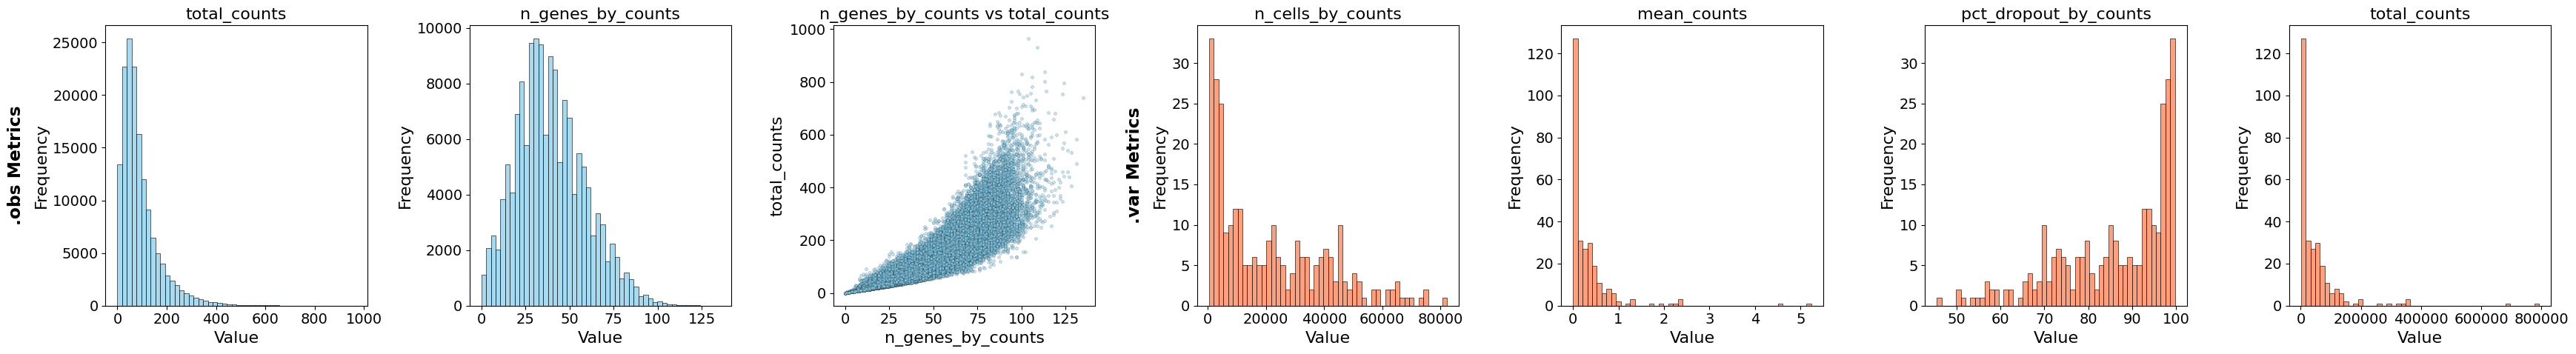

In [15]:
plot_qc_metrics(adata, show_inset=False)

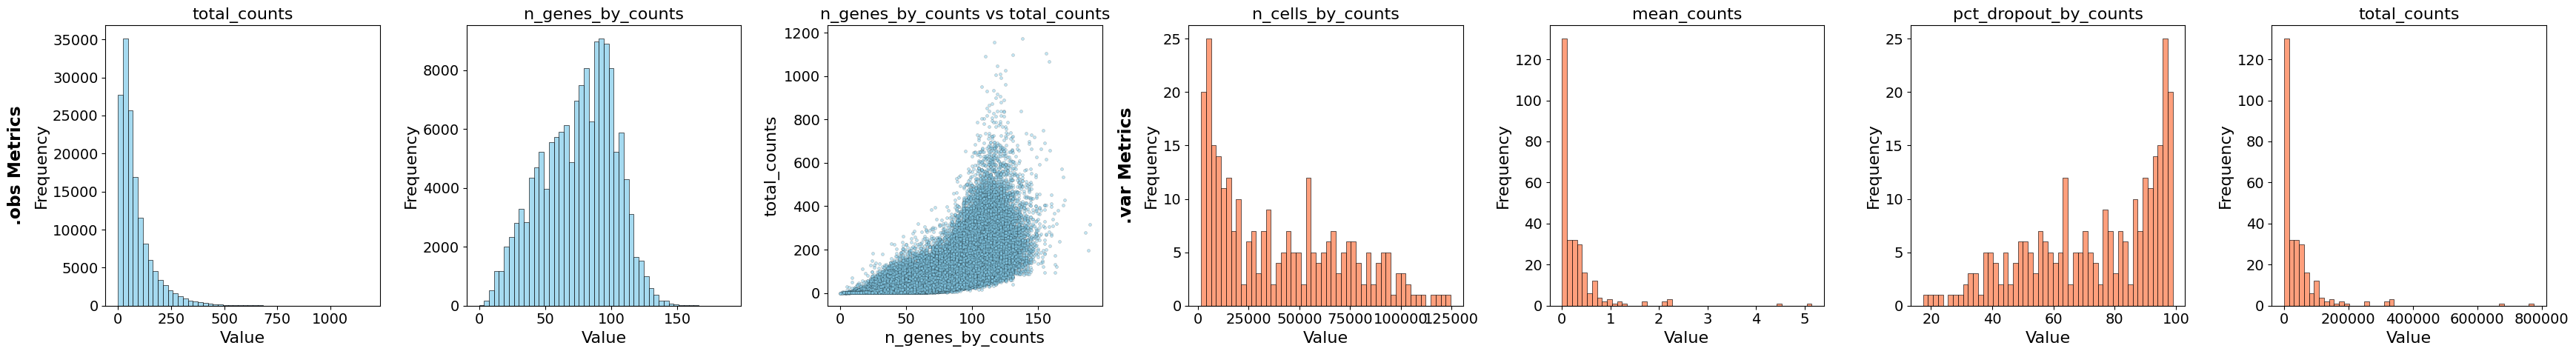

In [16]:
plot_qc_metrics(proseg_adata, show_inset=False)

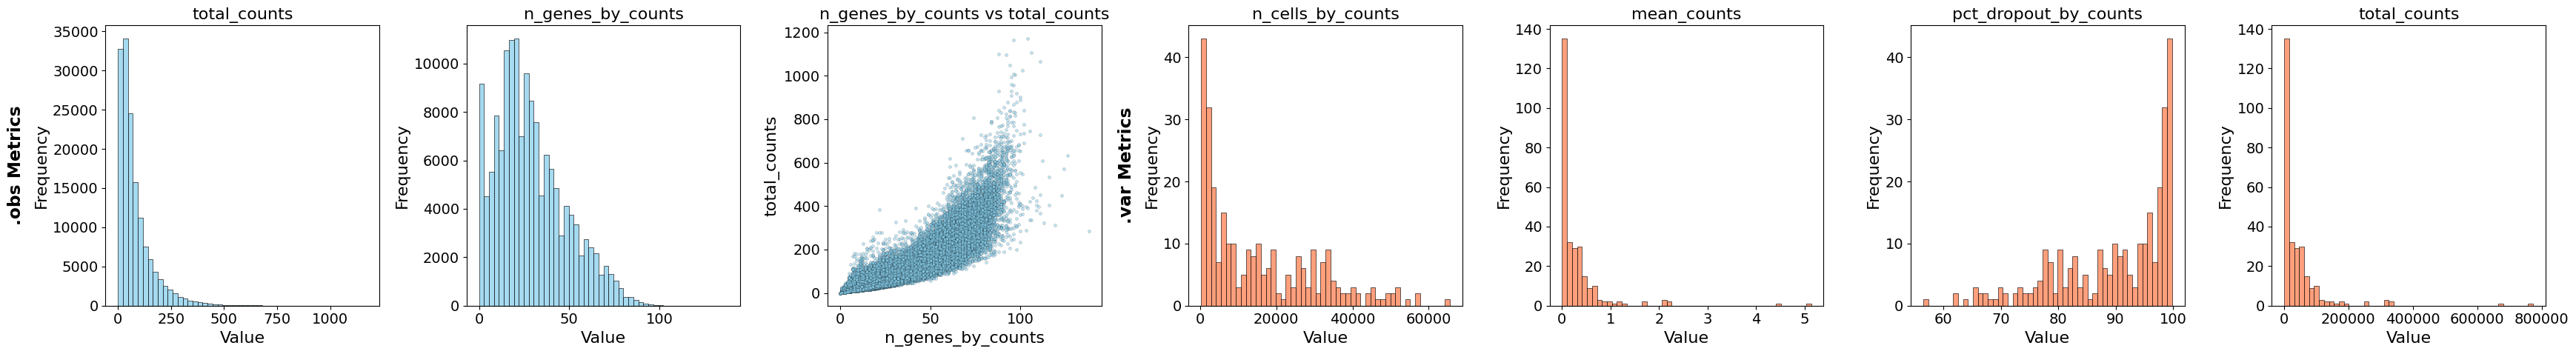

In [17]:
plot_qc_metrics(proseg_adata_rounded, show_inset=False)

### Filter proseg results by size

Here we filter out very large or very small cells.

In [18]:
upper = []
for _, xd in exp.iterdata():
    upper.append(xd.cells["proseg"].matrix.obs["volume"].quantile(0.95))
upper_size_limit = np.median(upper)

lower = []
for _, xd in exp.iterdata():
    lower.append(xd.cells["proseg"].matrix.obs["volume"].quantile(0.05))
lower_size_limit = np.median(lower)

In [19]:
print(upper_size_limit)
print(lower_size_limit)

1887.8148
213.38353


In [20]:
for _, xd in exp.iterdata():
    adata = xd.cells["proseg"].matrix
    mask1 = adata.obs["volume"] > lower_size_limit
    mask2 = adata.obs["volume"] < upper_size_limit
    xd.cells["proseg"].matrix = adata[mask1 & mask2].copy()
    xd.cells.sync()

In [21]:
exp.show(0)

## Check decimals of proseg data

In [22]:
ar = exp.data[0].cells["proseg"].matrix.X.toarray().flatten()

In [23]:
import matplotlib.pyplot as plt
fractional_part = np.modf(ar)[0]
integral_part = np.modf(ar)[1]

For all values below 1, most of the fractional parts are close to zero. Most values will be rounded to 0 in this case.

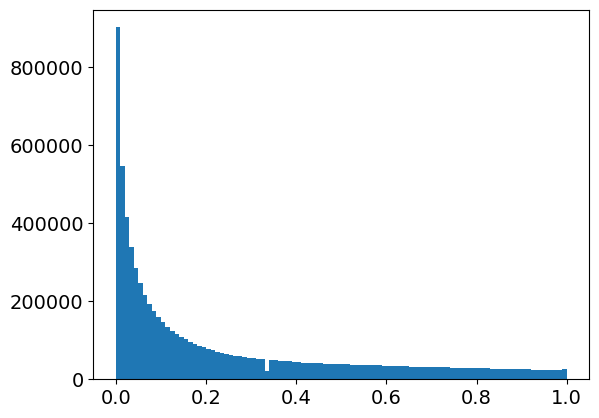

In [25]:
d = fractional_part[integral_part == 0]
d = d[d > 0]
plt.hist(d, bins=100)
plt.show()

For values above 1, the fractionals are more equally distributed.

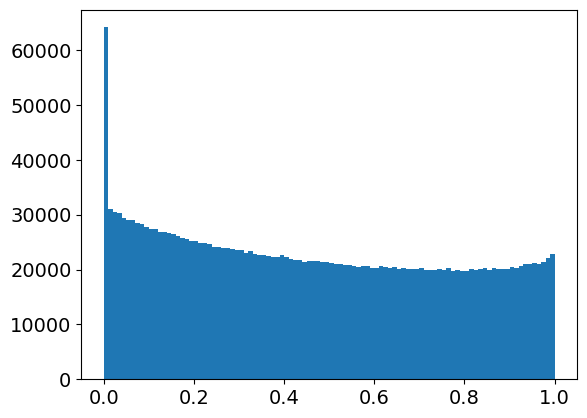

In [26]:
d = fractional_part[integral_part > 0]
d = d[d > 0]
plt.hist(d, bins=100)
plt.show()

## Set rounded counts as `.X`

In [27]:
for _, d in tqdm(exp.iterdata()):
    # save proseg counts
    d.cells["proseg"].matrix.layers["counts_proseg"] = d.cells["proseg"].matrix.X.copy()

    # set rounded counts as .X
    d.cells["proseg"].matrix.X = d.cells["proseg"].matrix.layers["counts_rounded"]

7it [00:00, 24.44it/s]


## Calculate QC metrics

### For `"main"` layer

In [28]:
calculate_qc_metrics(
    data=exp, cells_layer=None, percent_top=None, log1p=False
)

7it [00:00, 11.18it/s]


### For `"proseg"` layer

In [29]:
calculate_qc_metrics(
    data=exp, cells_layer='proseg', percent_top=None, log1p=False
)

7it [00:00,  7.93it/s]


## Filter by counts

In [30]:
exp.data[0].cells.matrix

AnnData object with n_obs × n_vars = 151305 × 280
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'

In [31]:
exp.data[0].cells["proseg"].matrix

AnnData object with n_obs × n_vars = 129751 × 280
    obs: 'original_cell_id', 'centroid_x', 'centroid_y', 'centroid_z', 'fov', 'cluster', 'volume', 'scale', 'population', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    obsm: 'spatial'
    layers: 'counts_rounded', 'counts_proseg'

0-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


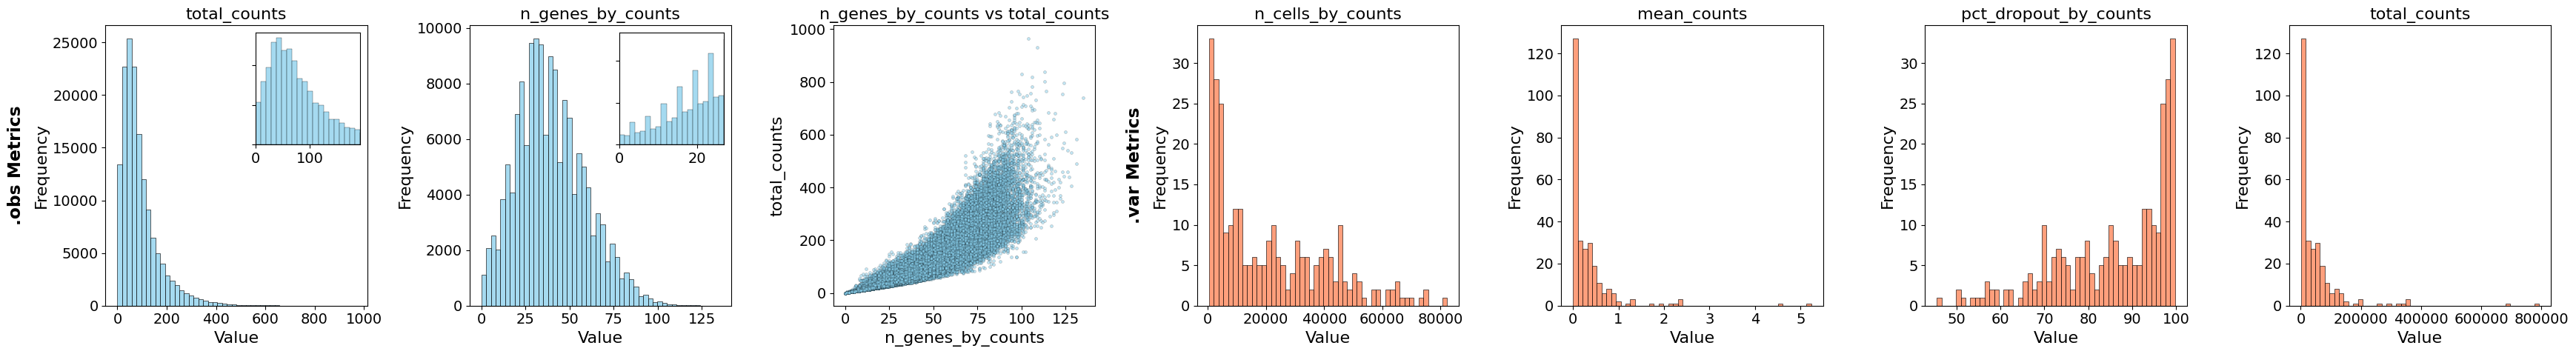

0-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


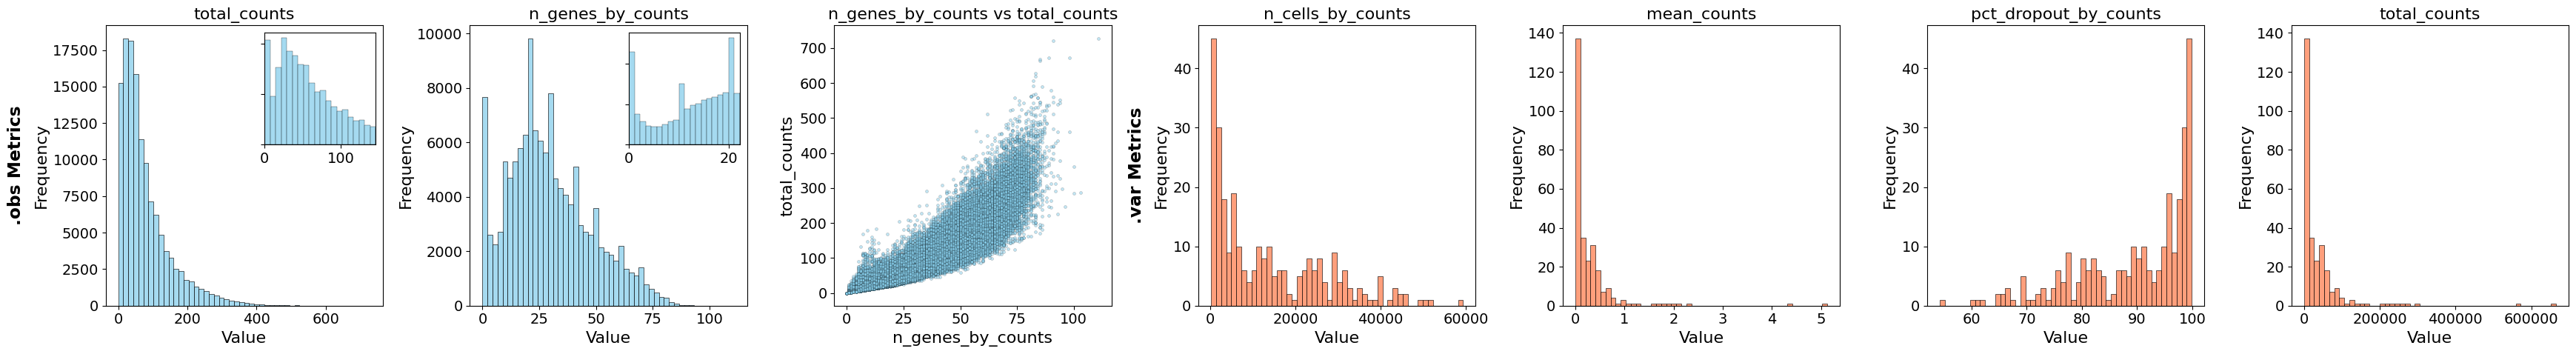

1-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


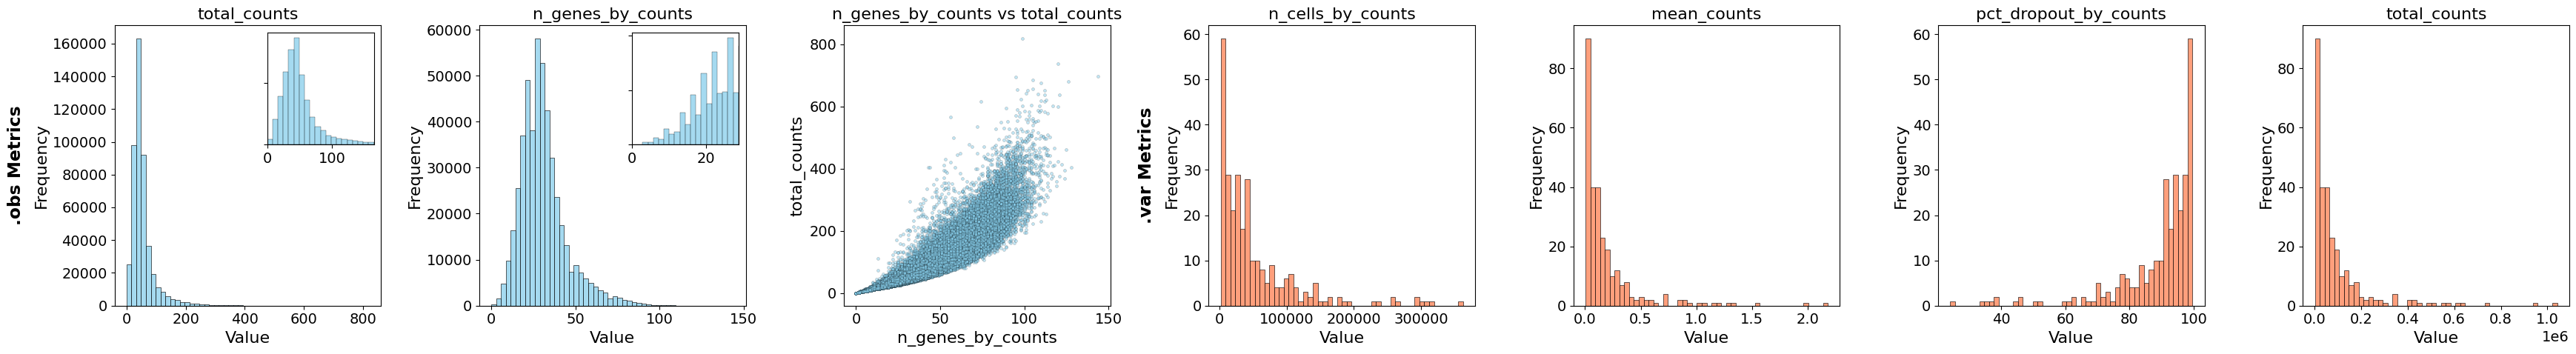

1-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


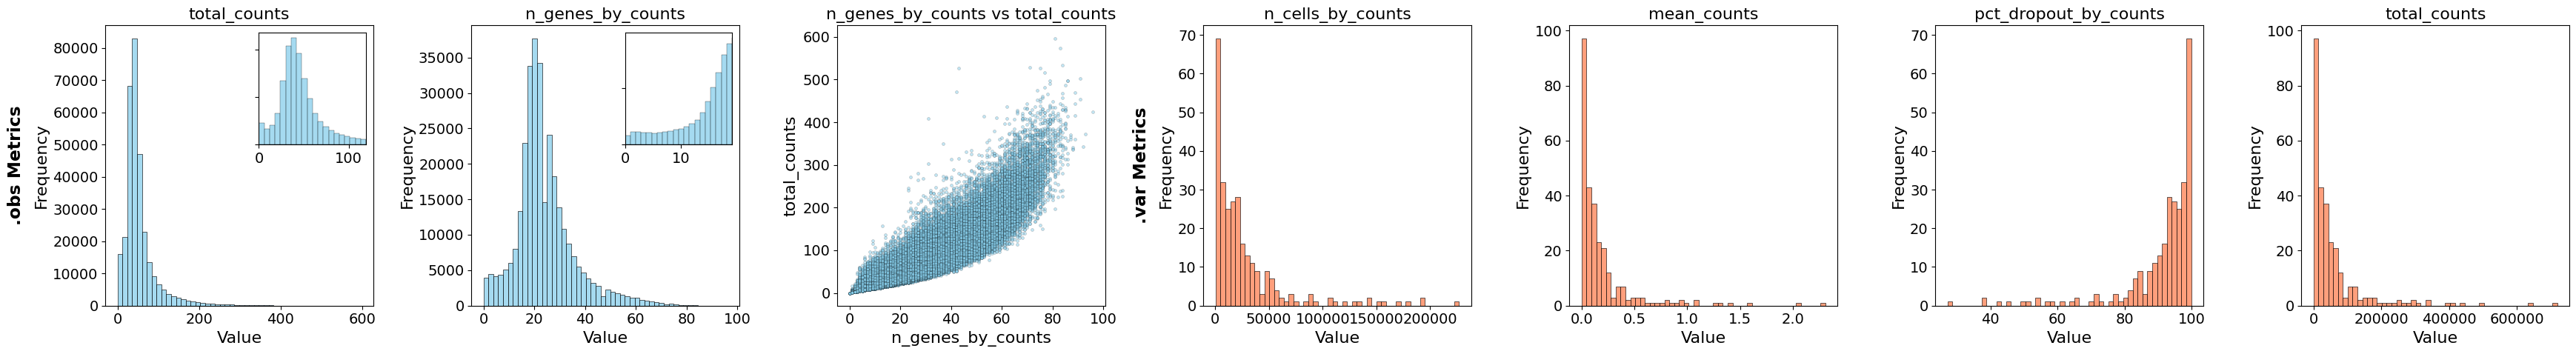

2-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


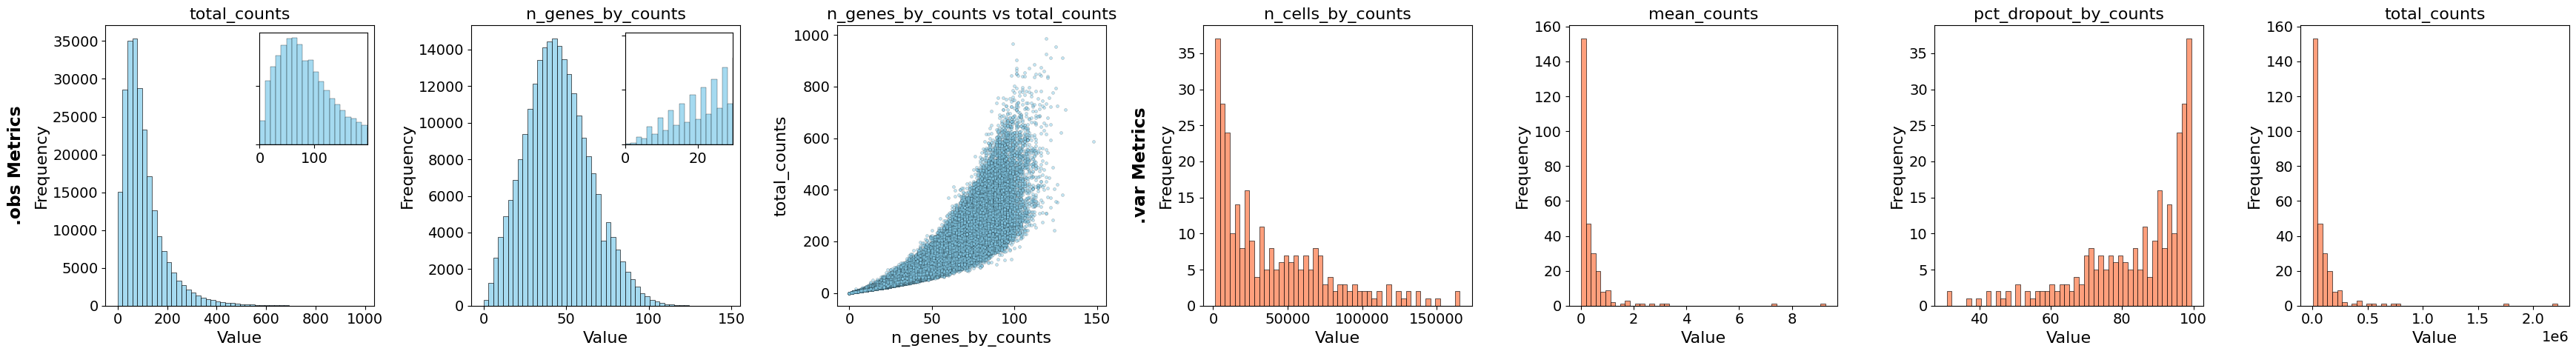

2-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


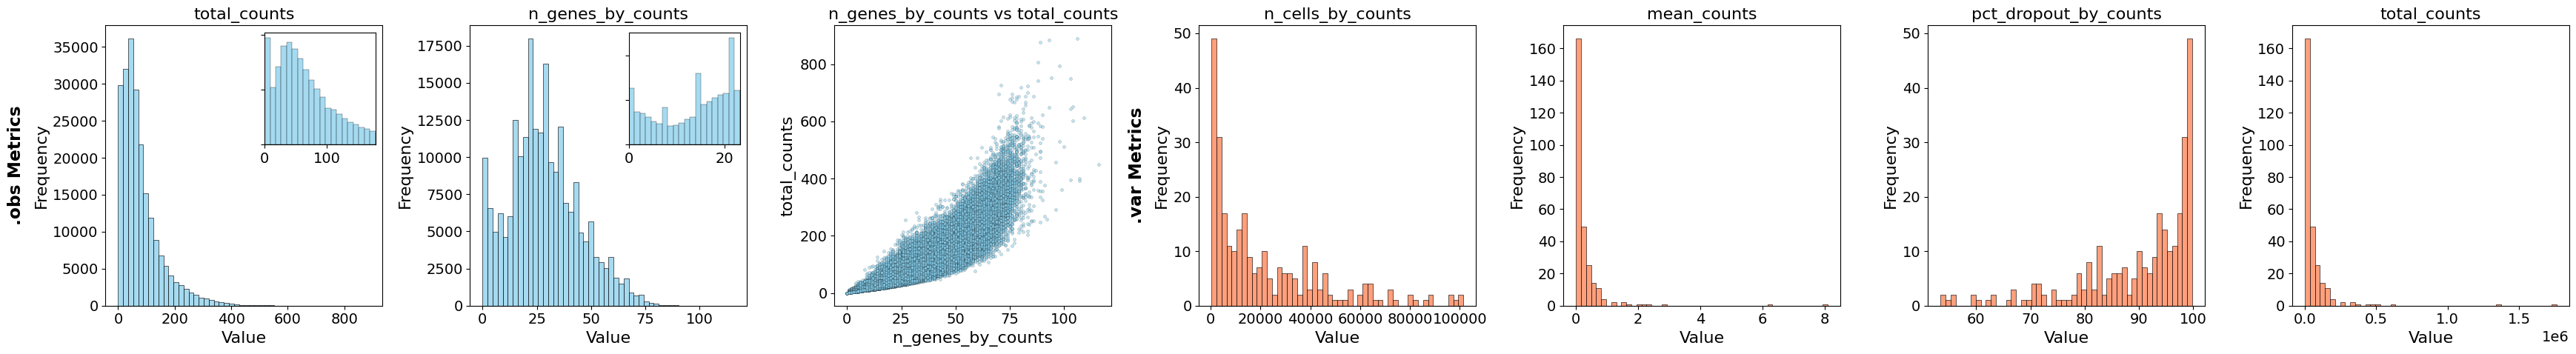

3-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


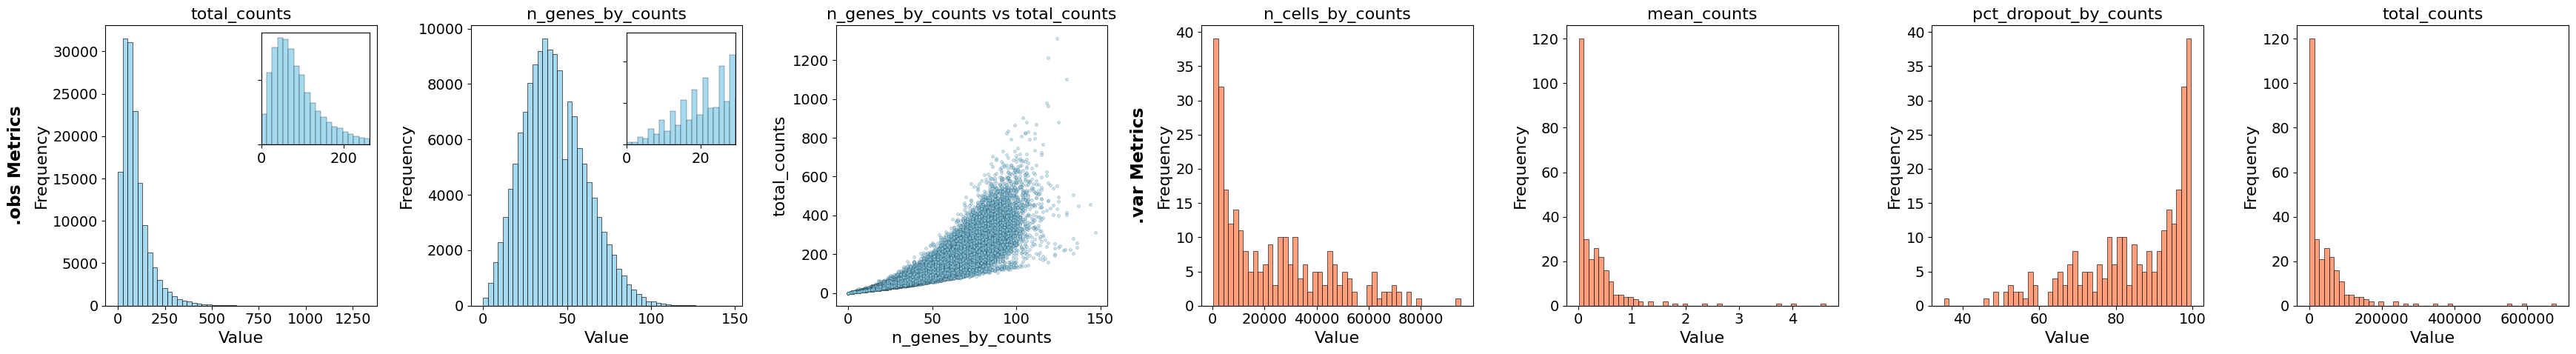

3-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


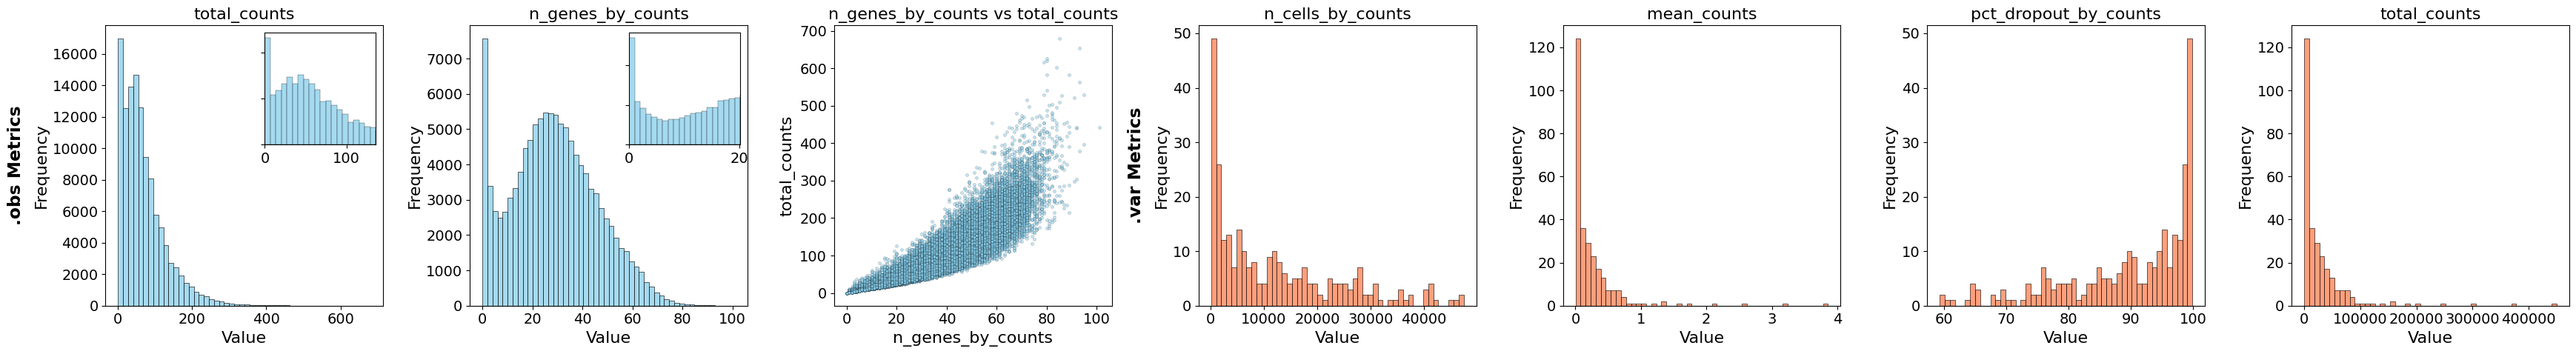

4-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


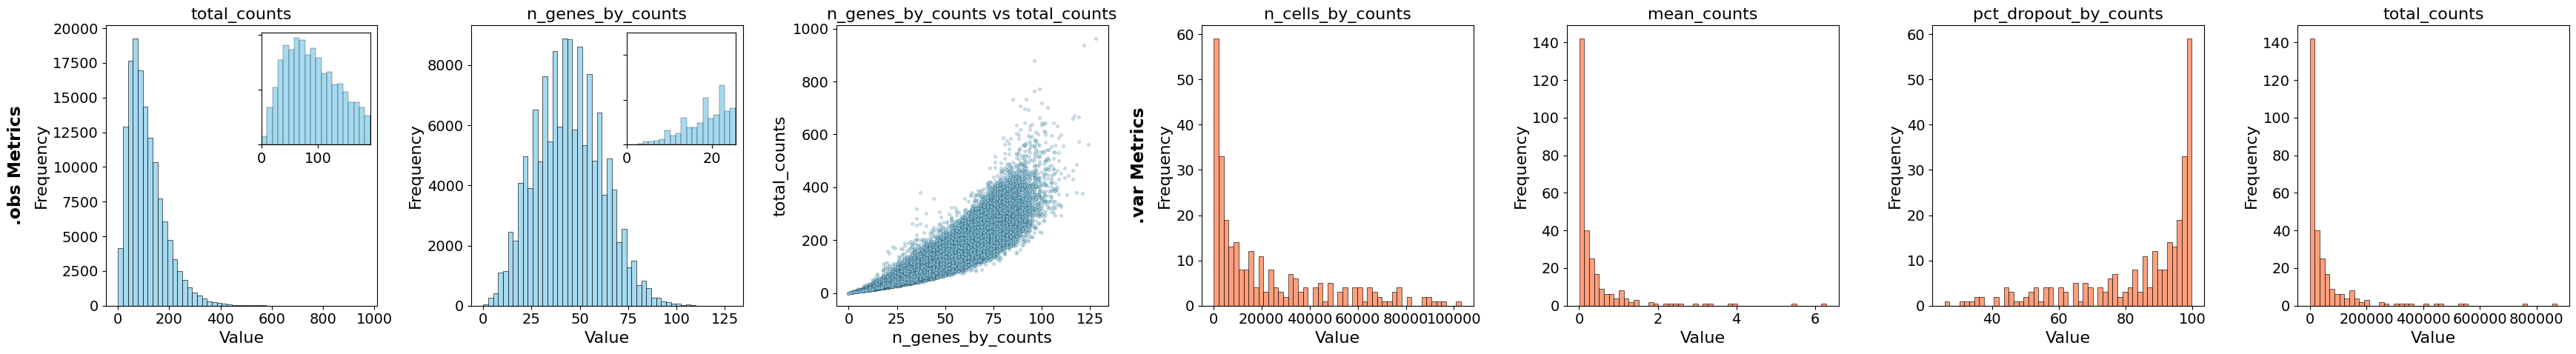

4-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


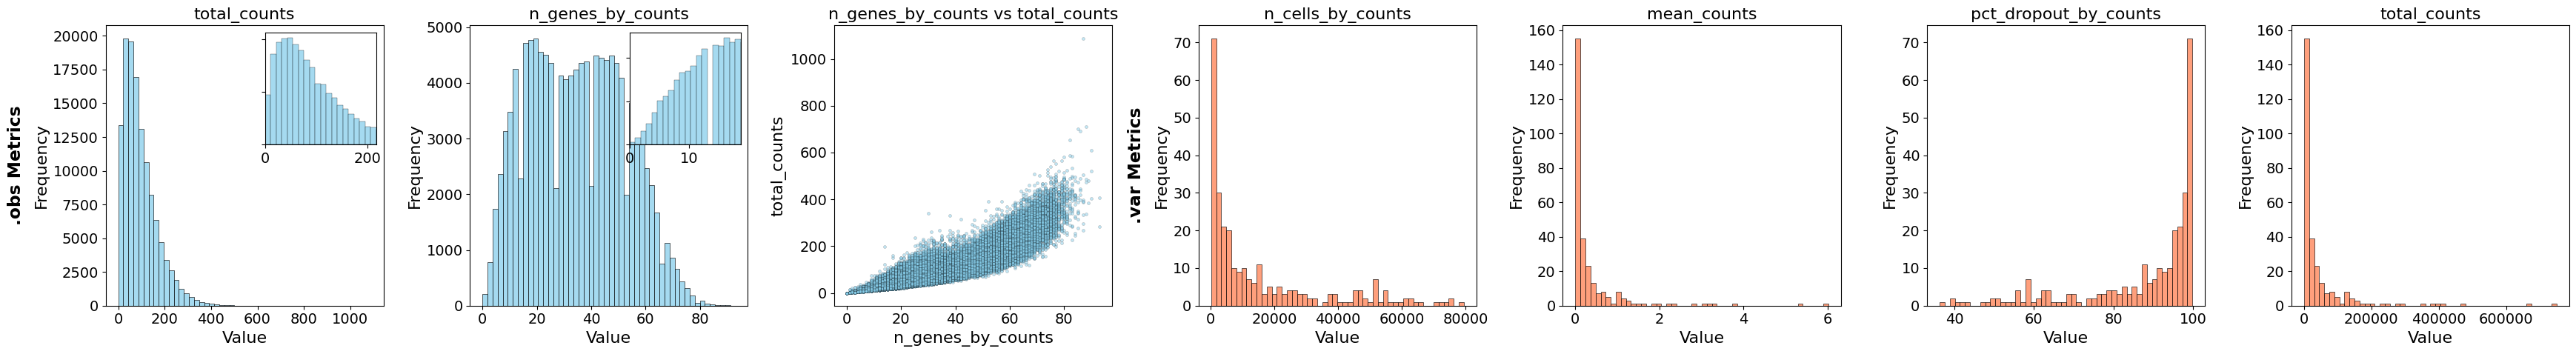

5-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


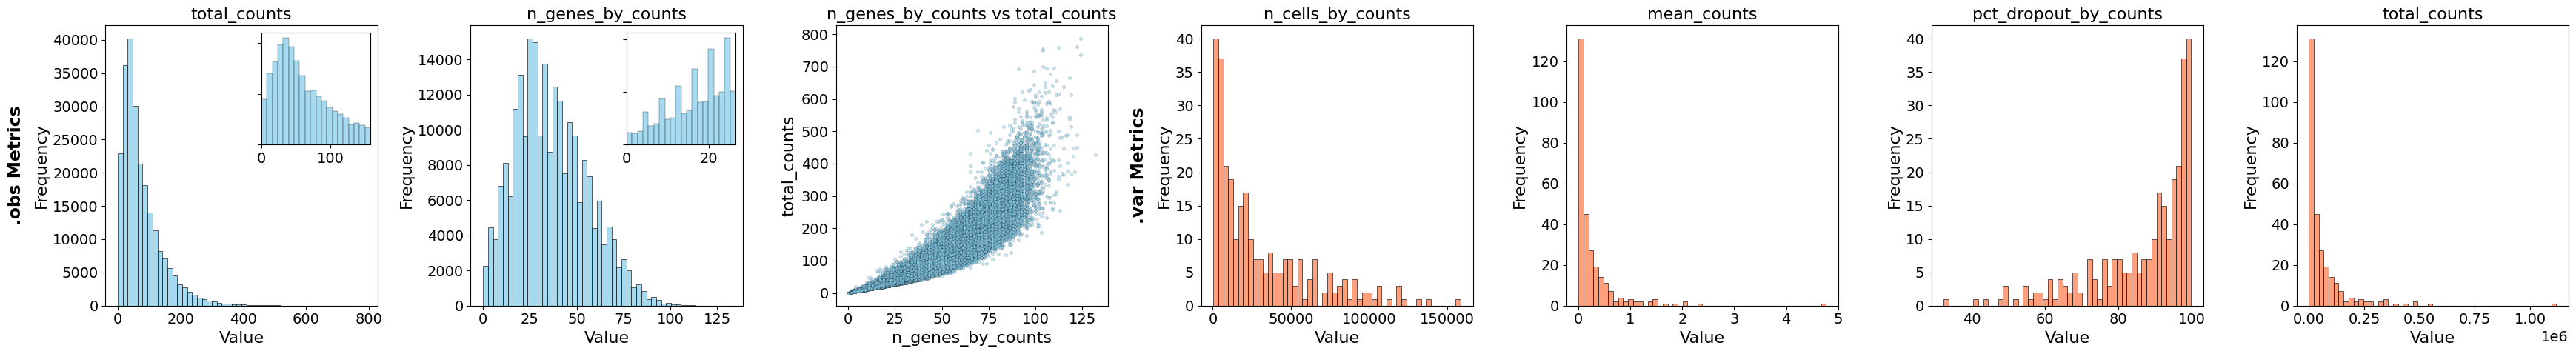

5-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


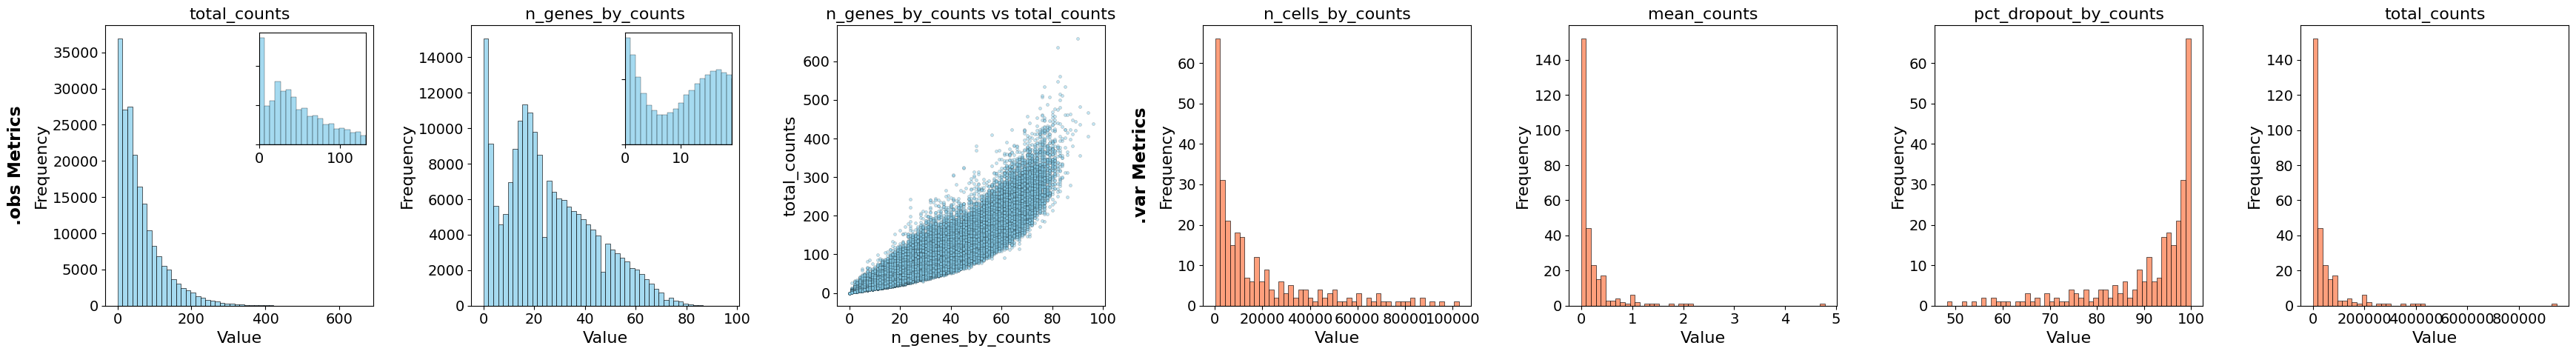

6-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


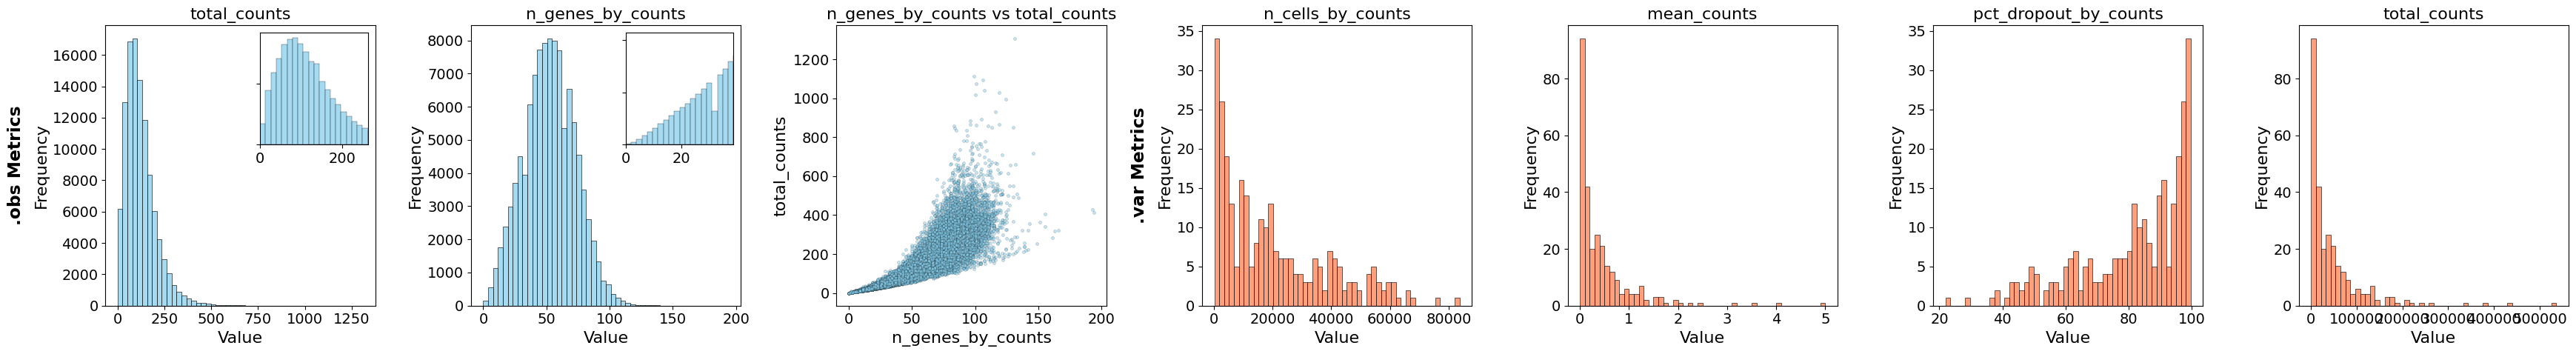

6-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


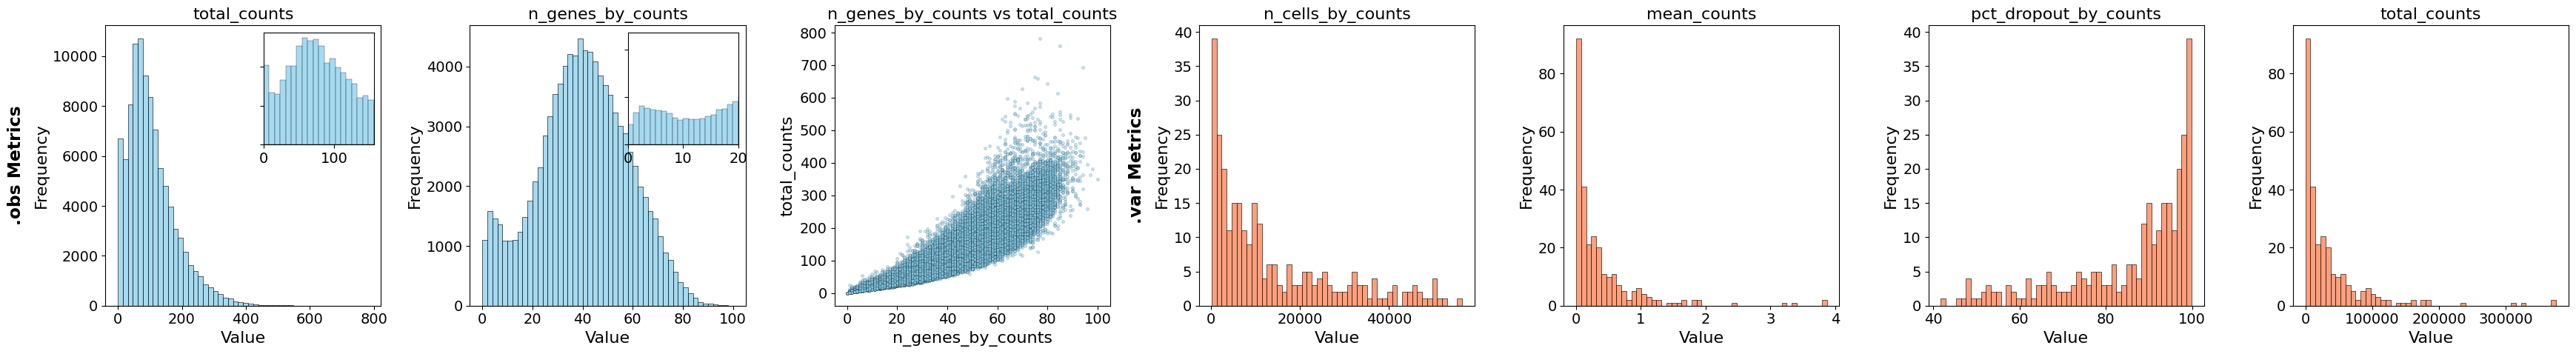

In [32]:
for meta, data in exp.iterdata():
    for k in cell_keys:
        print(f"{meta.name}-{k}")
        plot_qc_metrics(data, cells_layer=k)

### Do the filtering on cell level

In [33]:
from insitupy.preprocessing import filter_cells

First on the main data:

In [34]:
filter_cells(
    data=exp,
    cells_layer="main",
    min_counts=20
    #min_genes=thresholds["main"]
)

7it [00:03,  2.15it/s]


In [35]:
filter_cells(
    data=exp,
    cells_layer="main",
    min_genes=10
    #min_genes=thresholds["main"]
)

7it [00:03,  1.98it/s]


Then on the `"proseg"` data:

In [36]:
filter_cells(
    data=exp,
    cells_layer="proseg",
    min_counts=20
    #min_genes=thresholds["proseg"]
)

7it [00:03,  2.25it/s]


In [37]:
filter_cells(
    data=exp,
    cells_layer="proseg",
    min_genes=10,
    #min_genes=thresholds["proseg"]
)

7it [00:03,  1.81it/s]


## Recalculate QC metrics to update var metrics

In [38]:
calculate_qc_metrics(
    data=exp, cells_layer="main", percent_top=None, log1p=False
)

7it [00:00, 11.17it/s]


In [39]:
calculate_qc_metrics(
    data=exp, cells_layer='proseg', percent_top=None, log1p=False
)

7it [00:00, 15.41it/s]


0-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


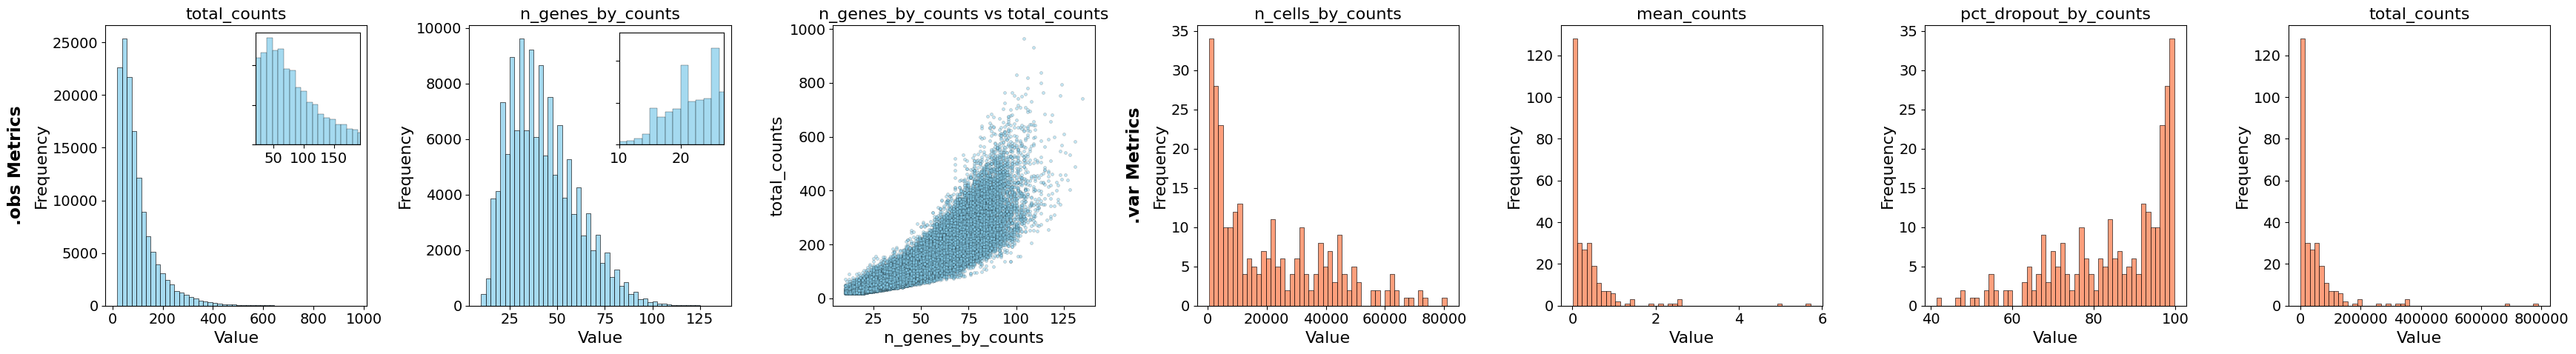

0-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


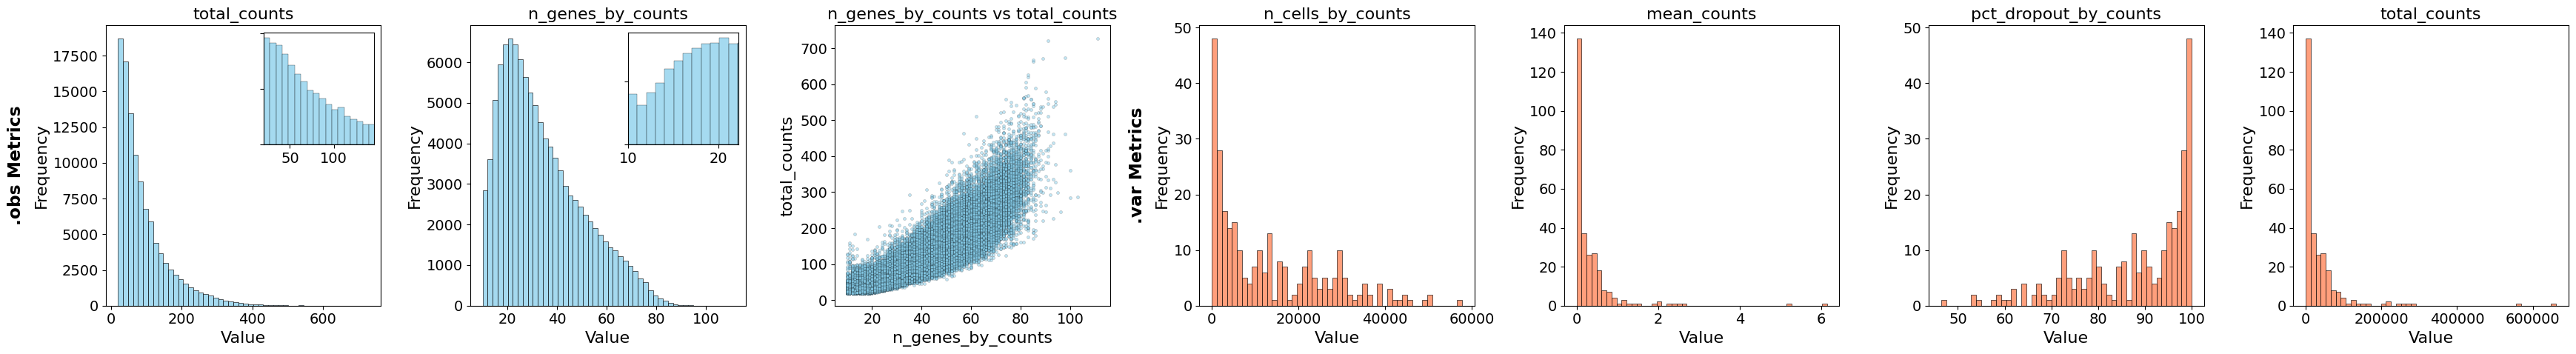

1-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


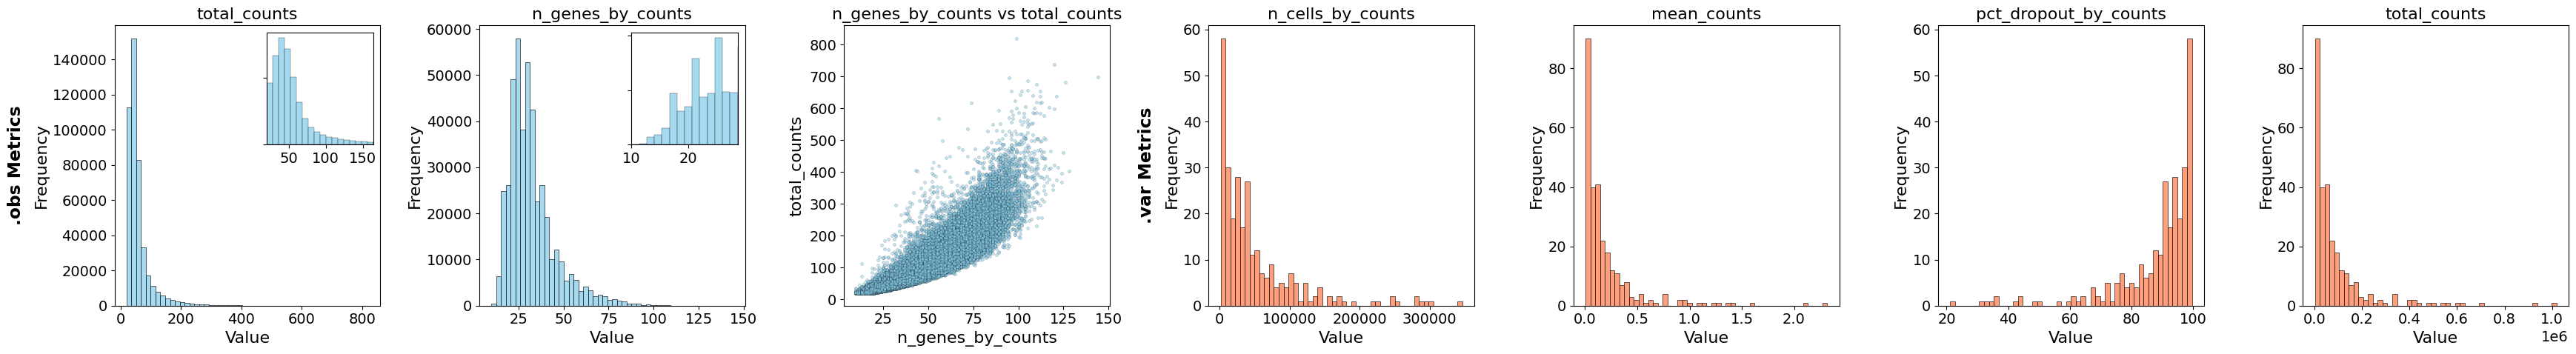

1-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


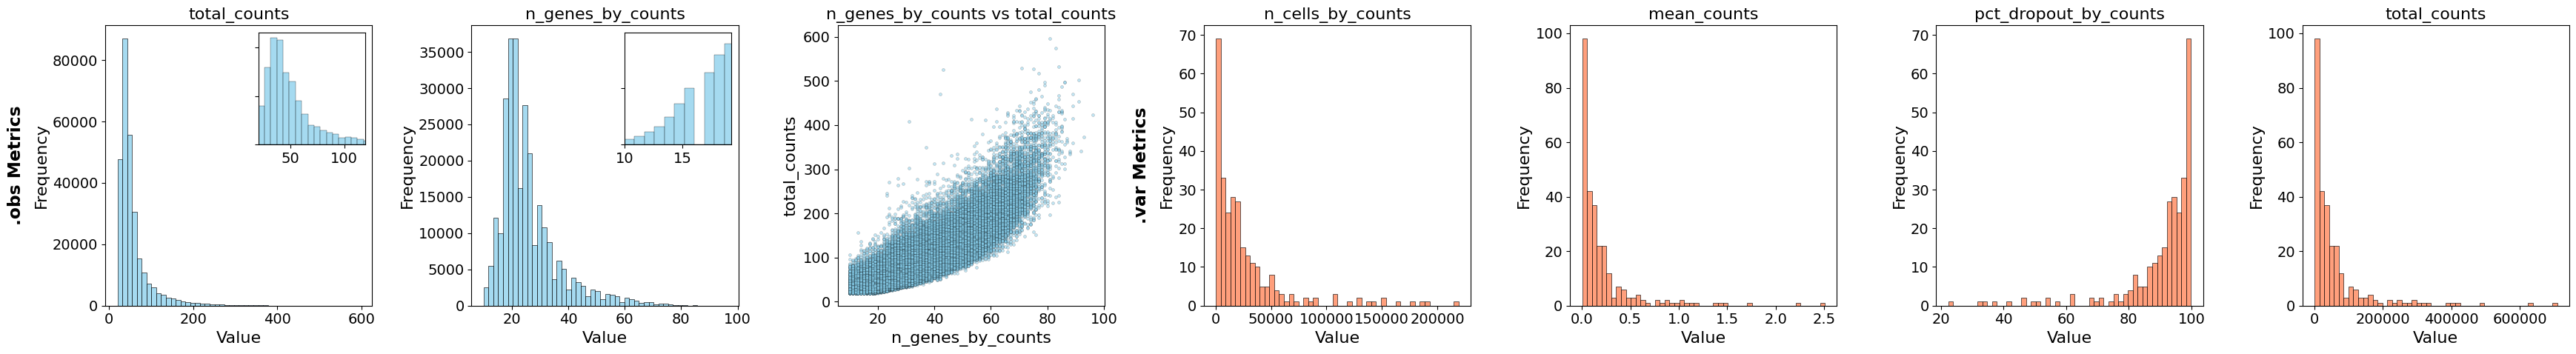

2-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


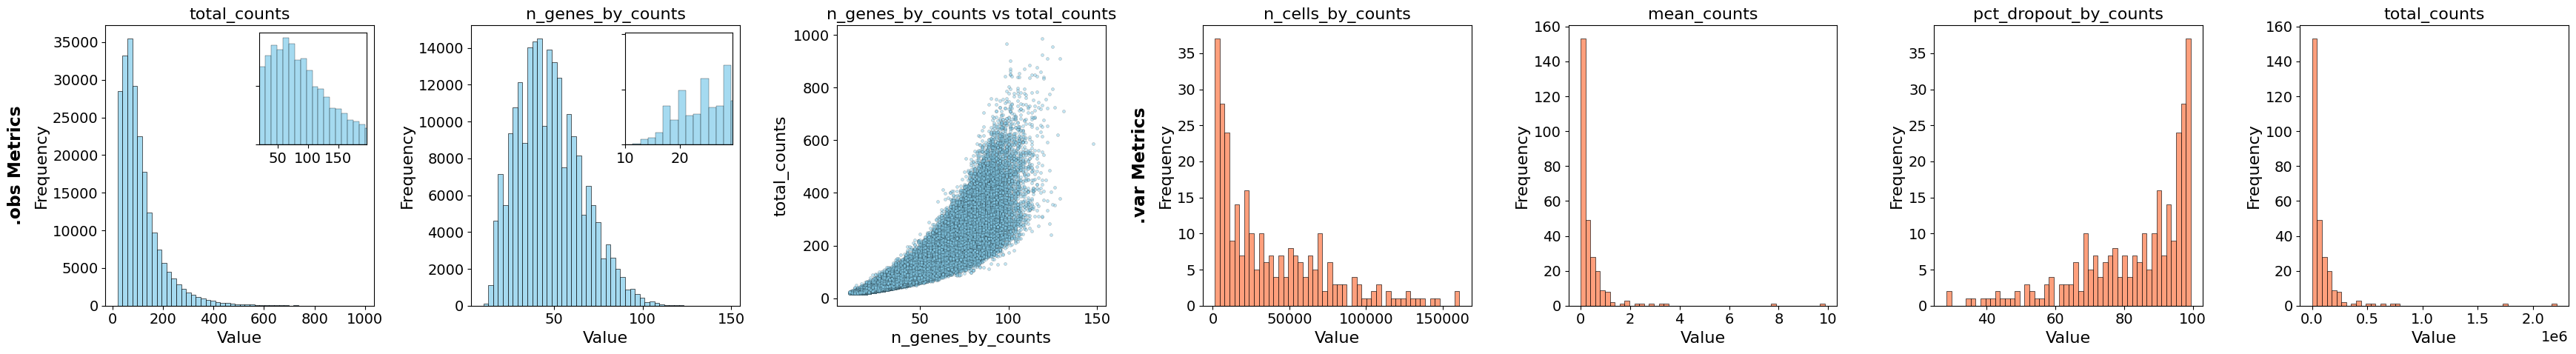

2-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


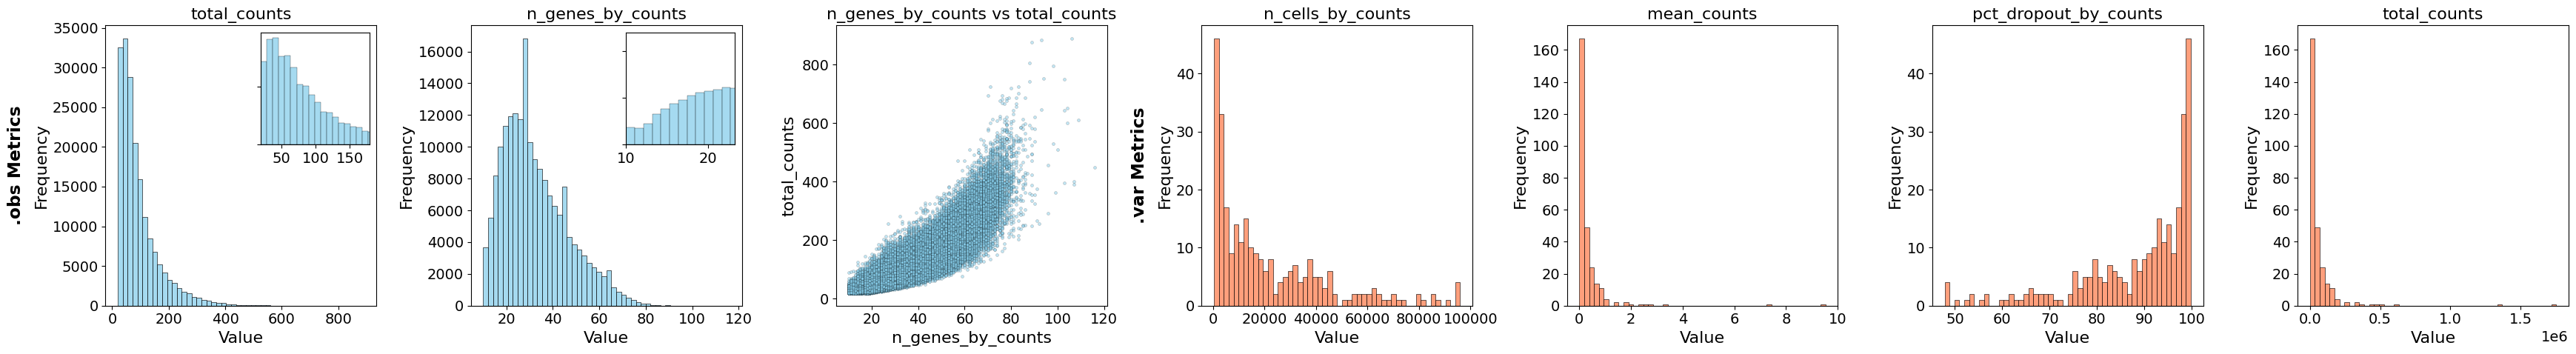

3-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


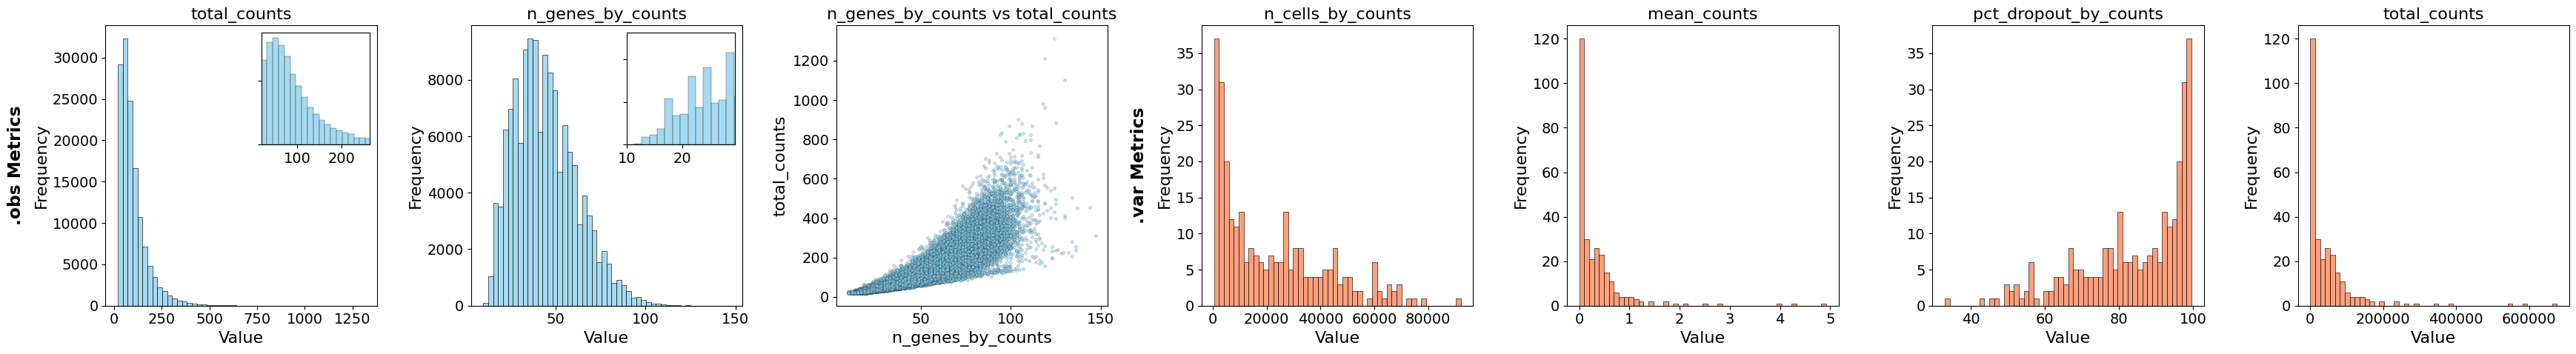

3-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


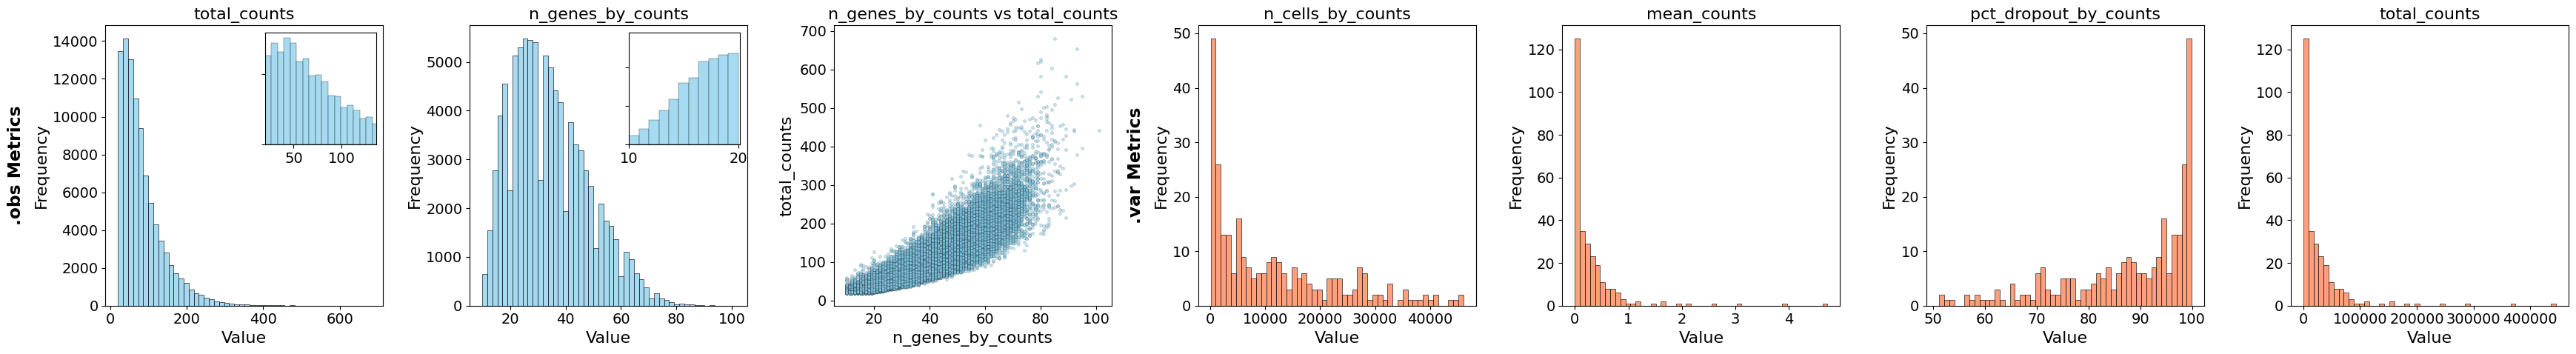

4-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


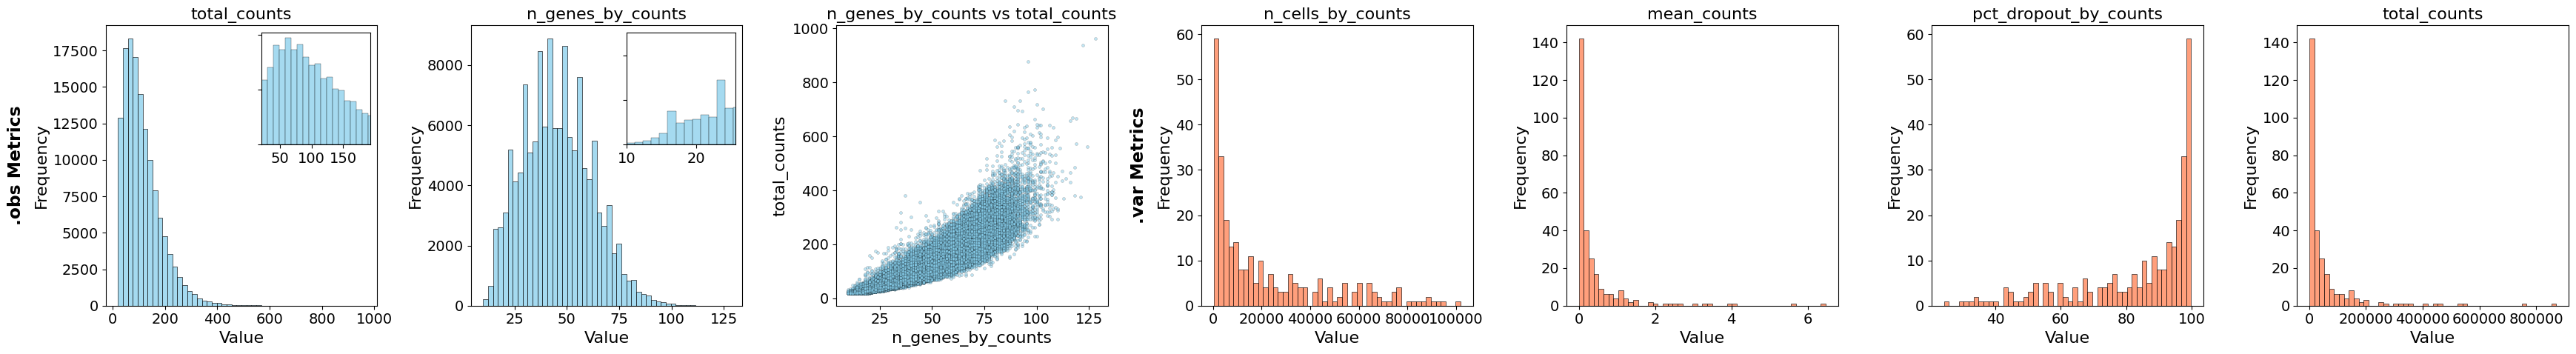

4-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


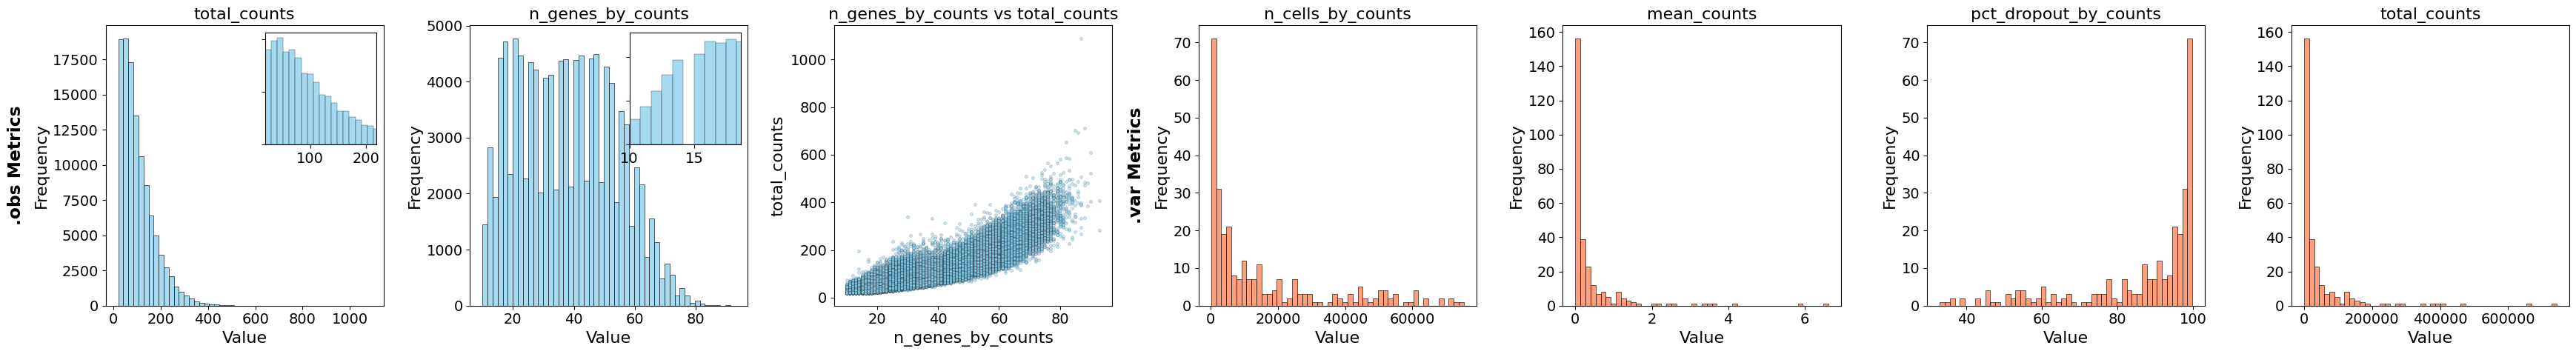

5-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


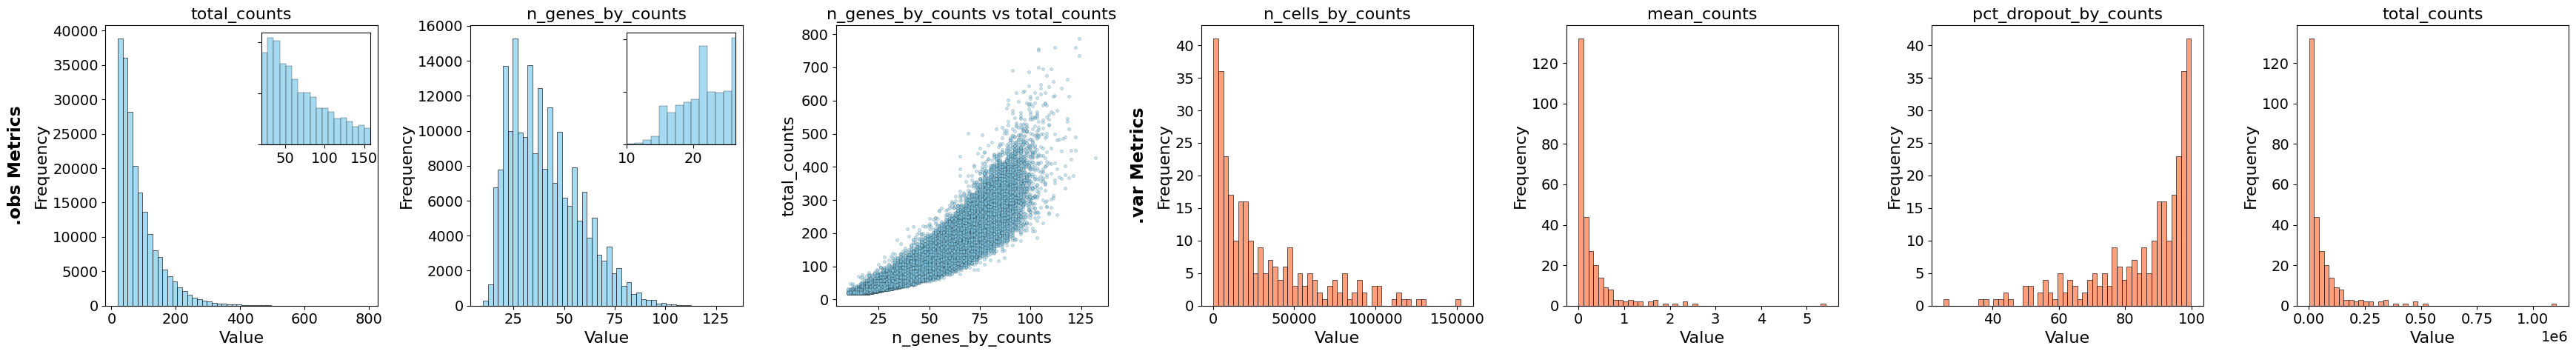

5-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


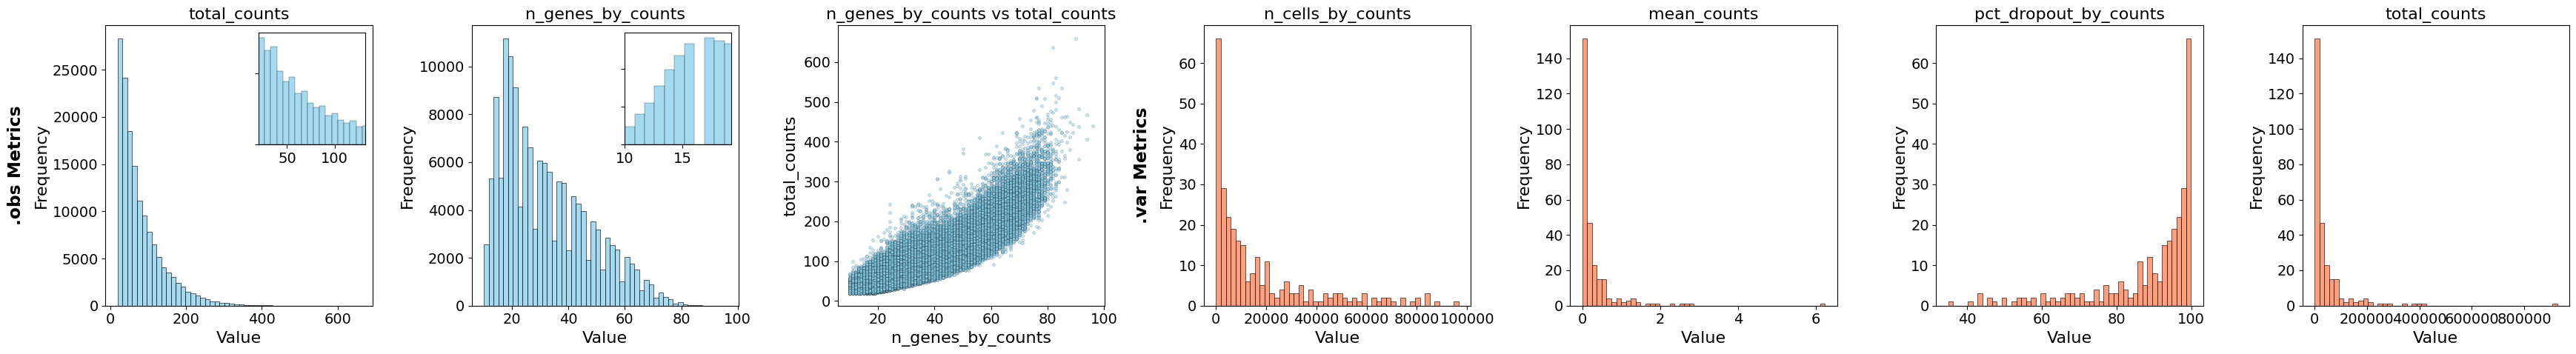

6-main


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


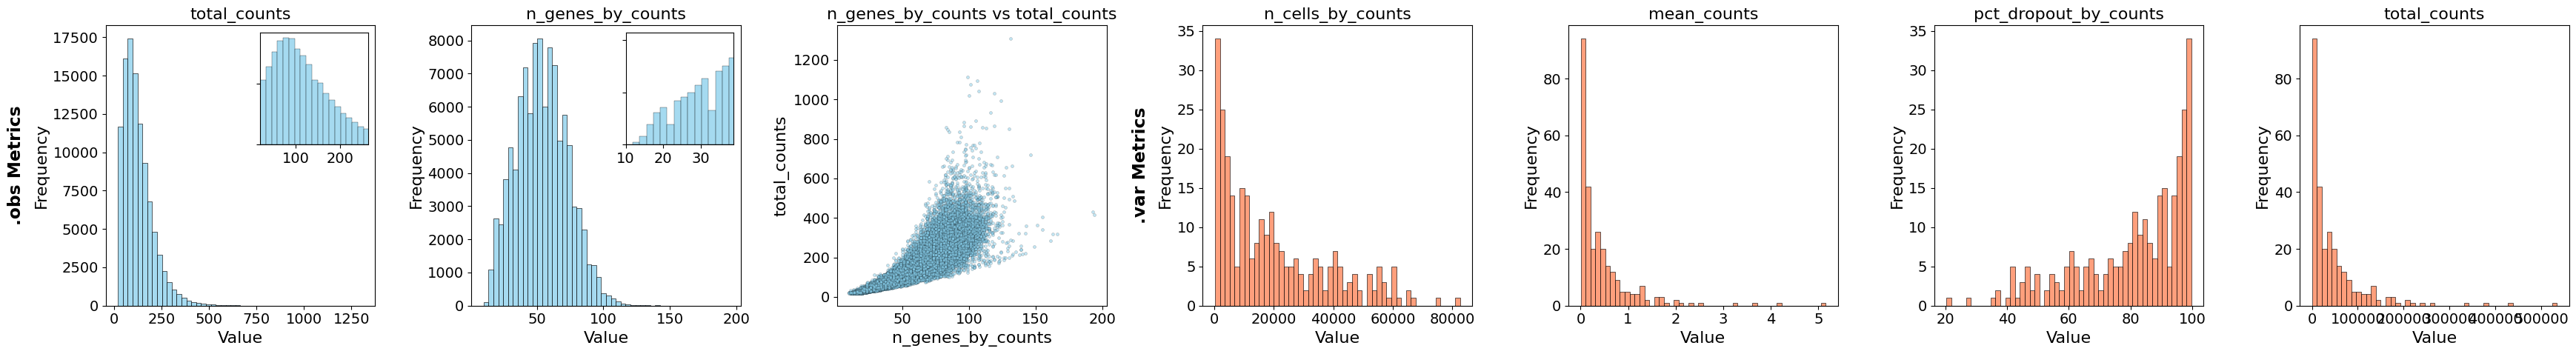

6-proseg


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\qc.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


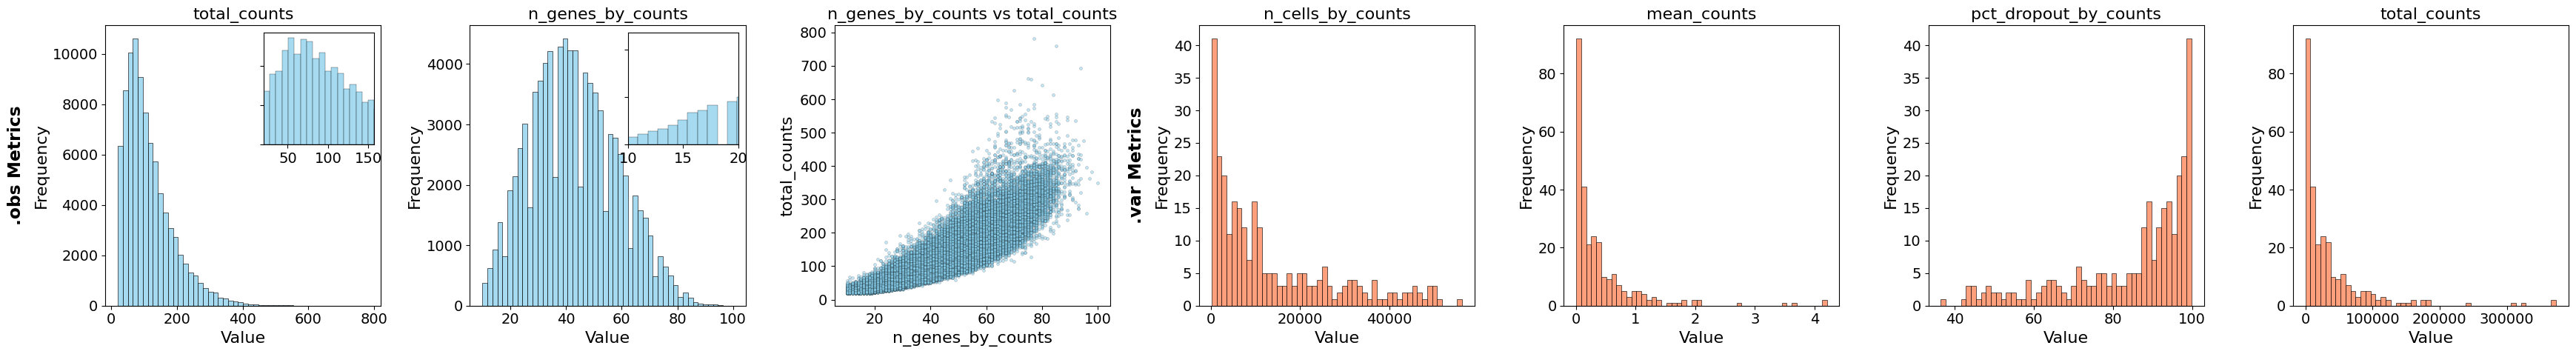

In [40]:
for meta, data in exp.iterdata():
    for k in cell_keys:
        print(f"{meta.name}-{k}")
        plot_qc_metrics(data, cells_layer=k)

## Normalization and transformation

In [41]:
from insitupy.plotting import test_transformations

0-main-without scaling


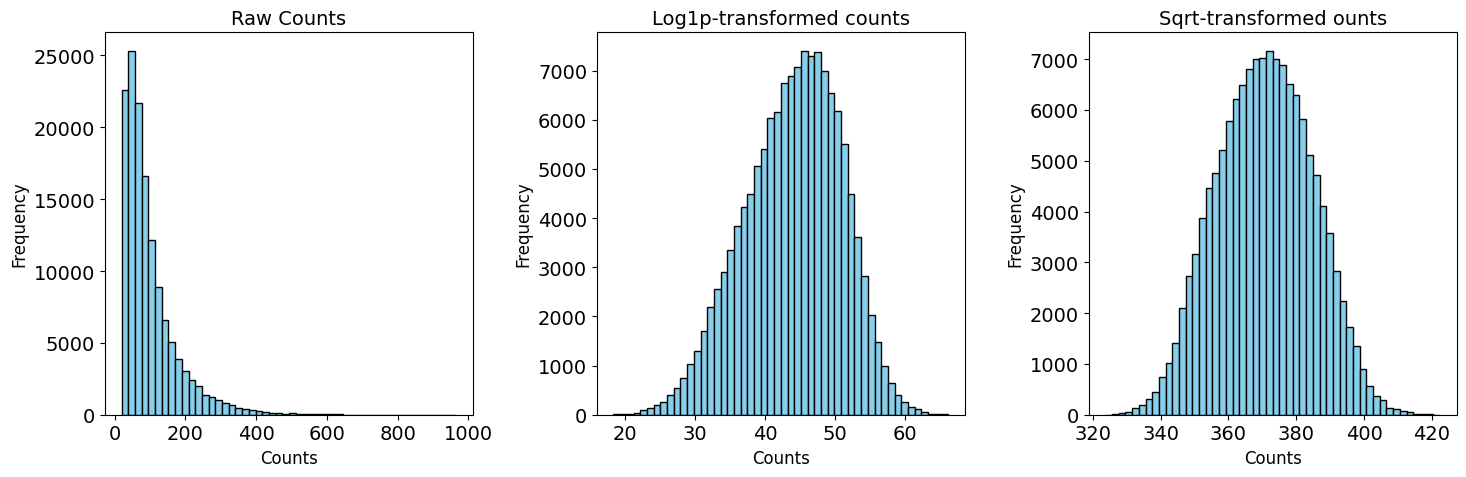

0-main-with scaling


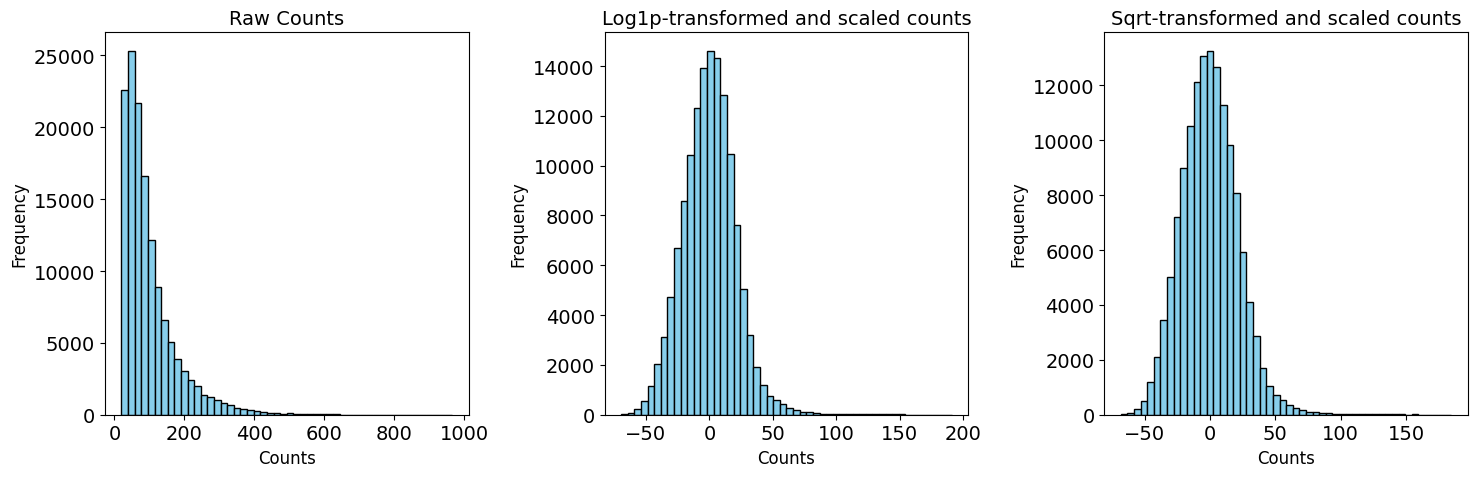

0-proseg-without scaling


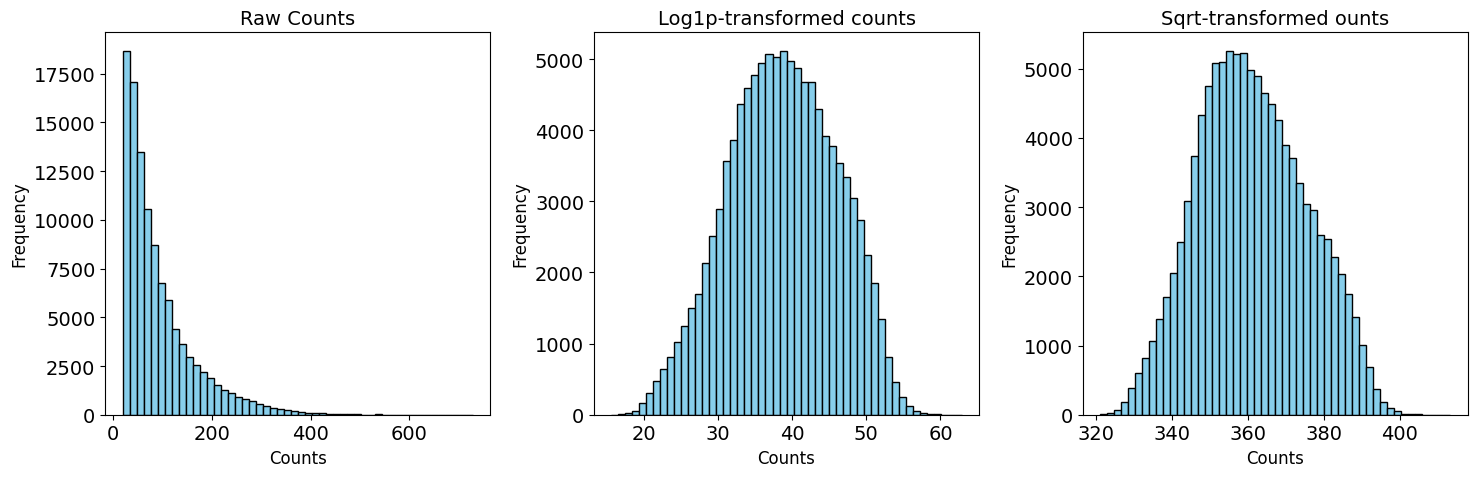

0-proseg-with scaling


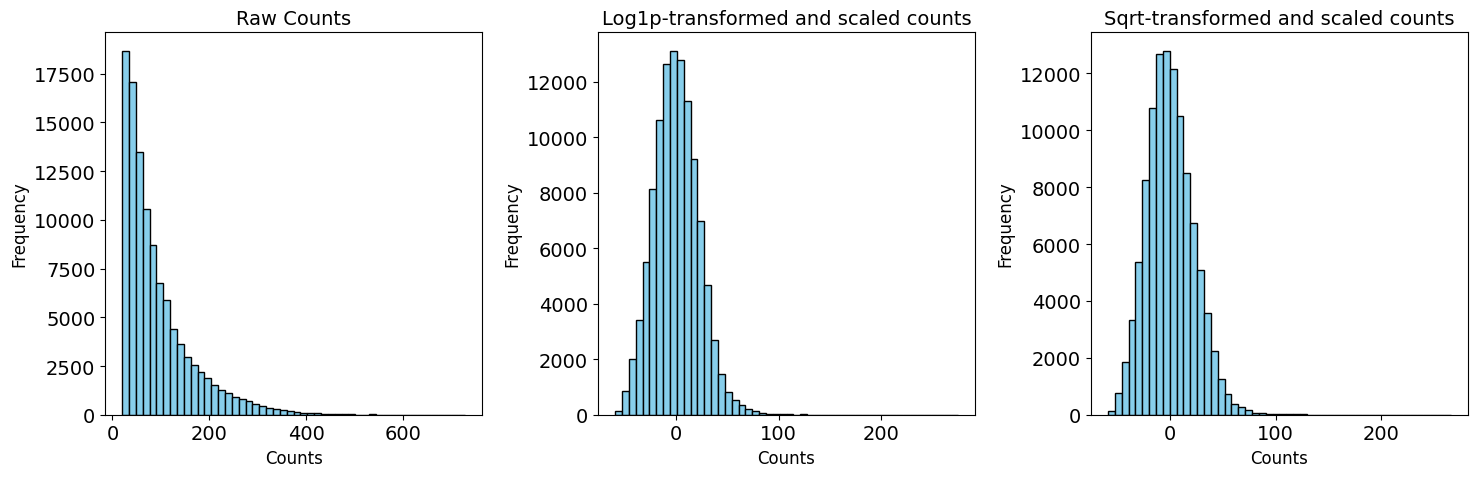

1-main-without scaling


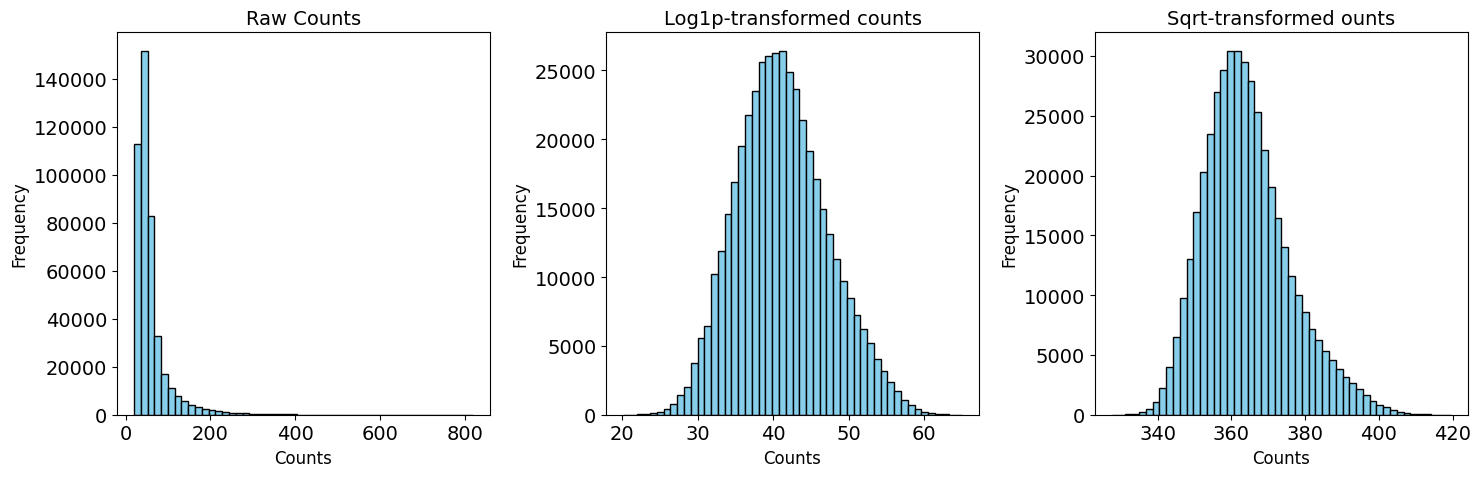

1-main-with scaling


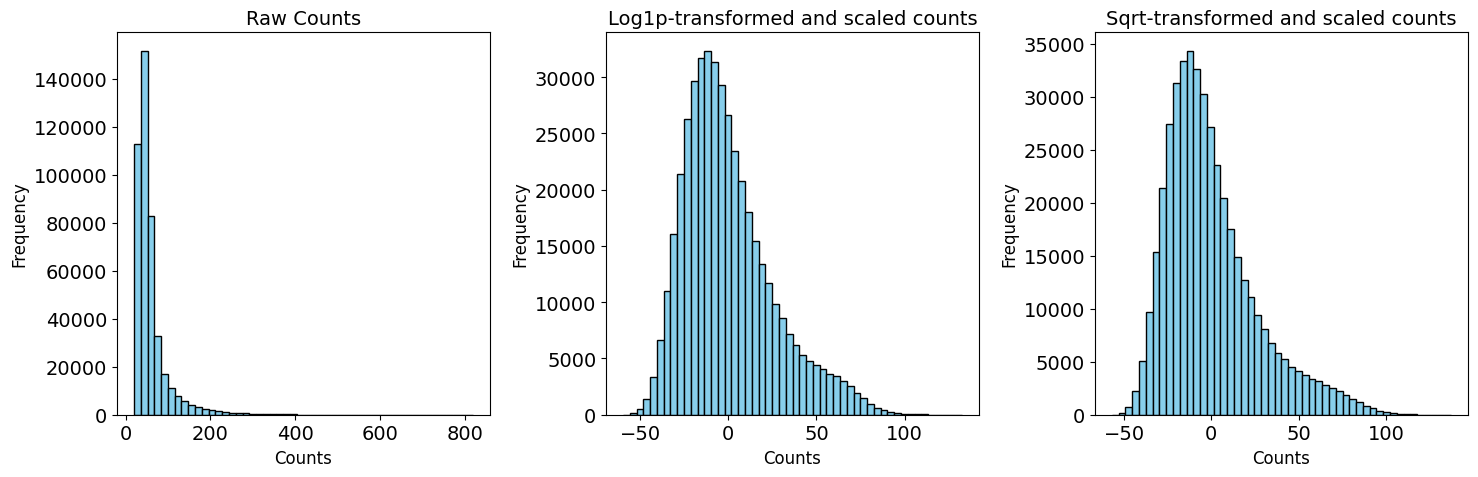

1-proseg-without scaling


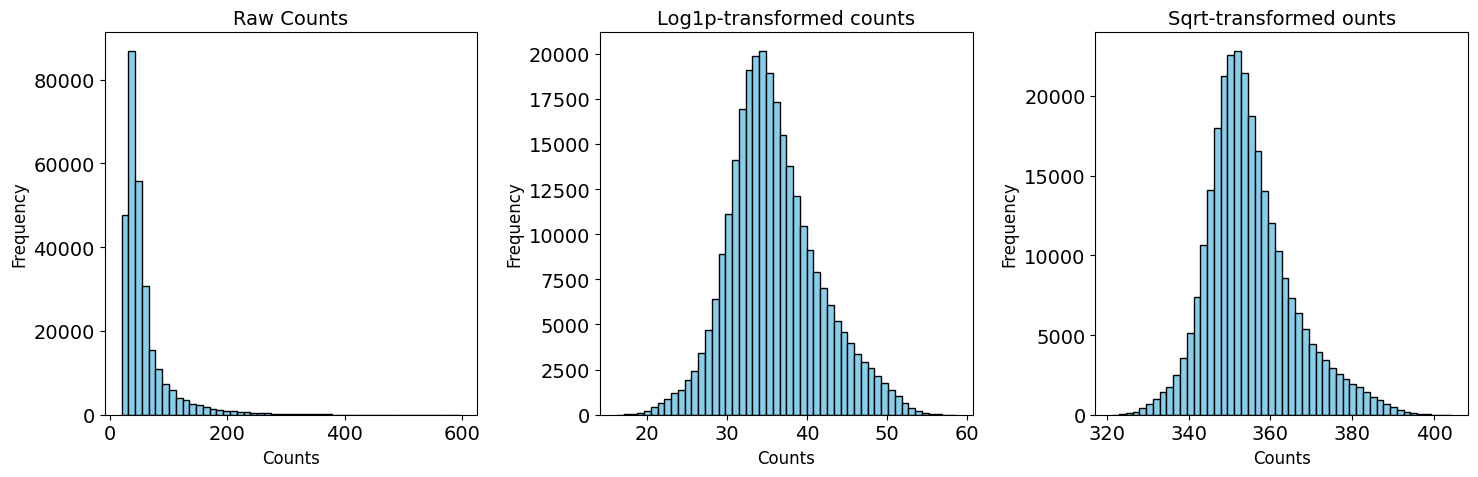

1-proseg-with scaling


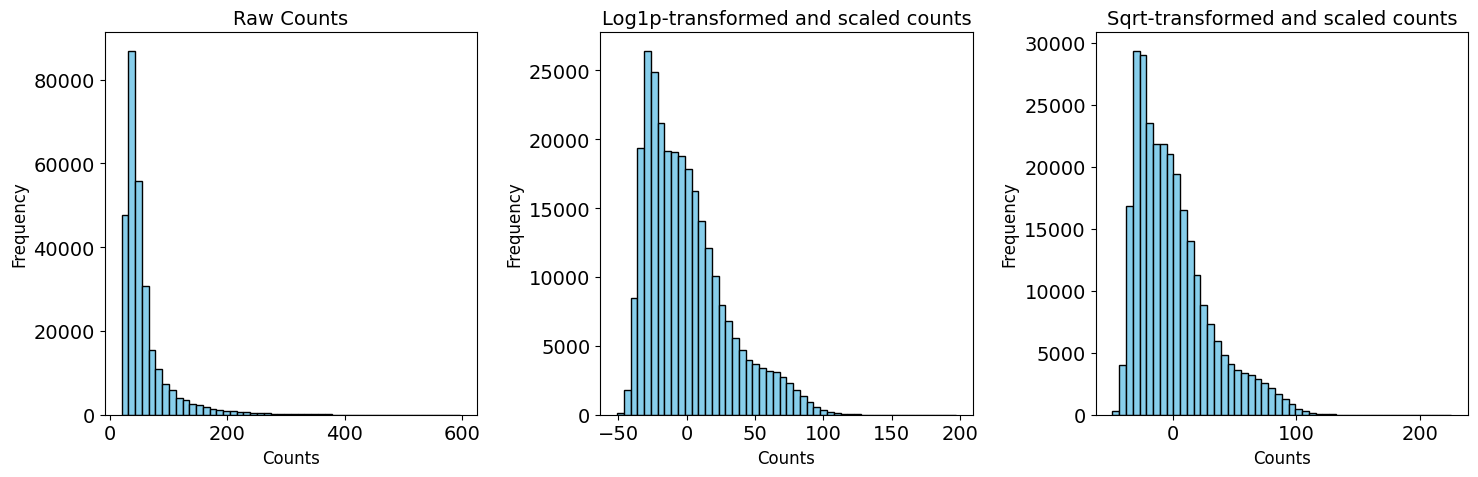

2-main-without scaling


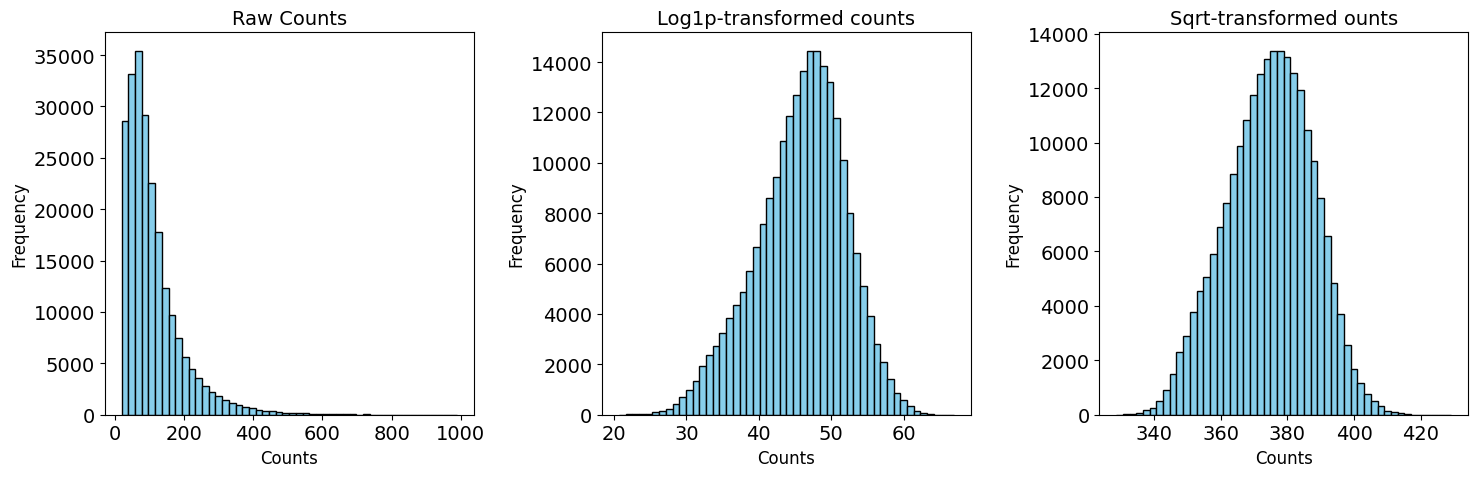

2-main-with scaling


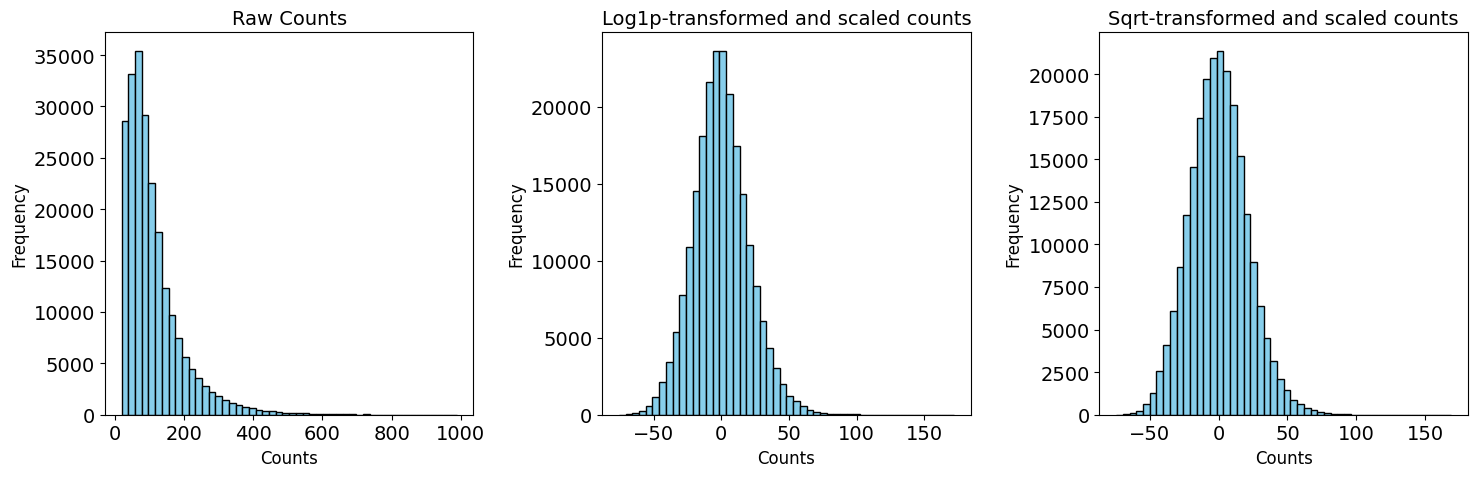

2-proseg-without scaling


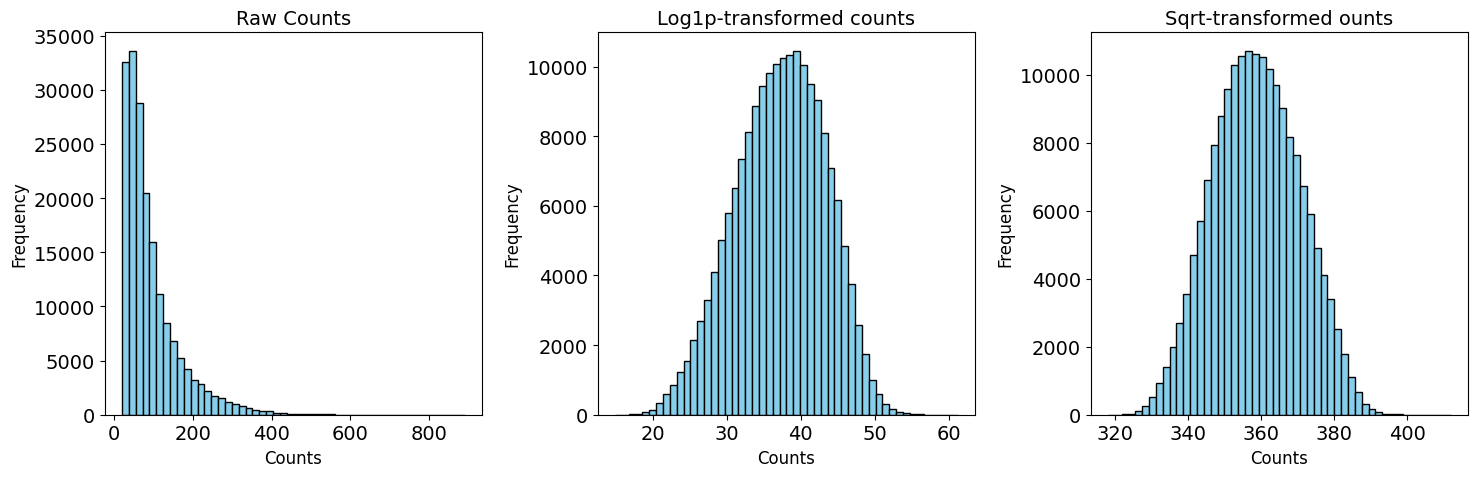

2-proseg-with scaling


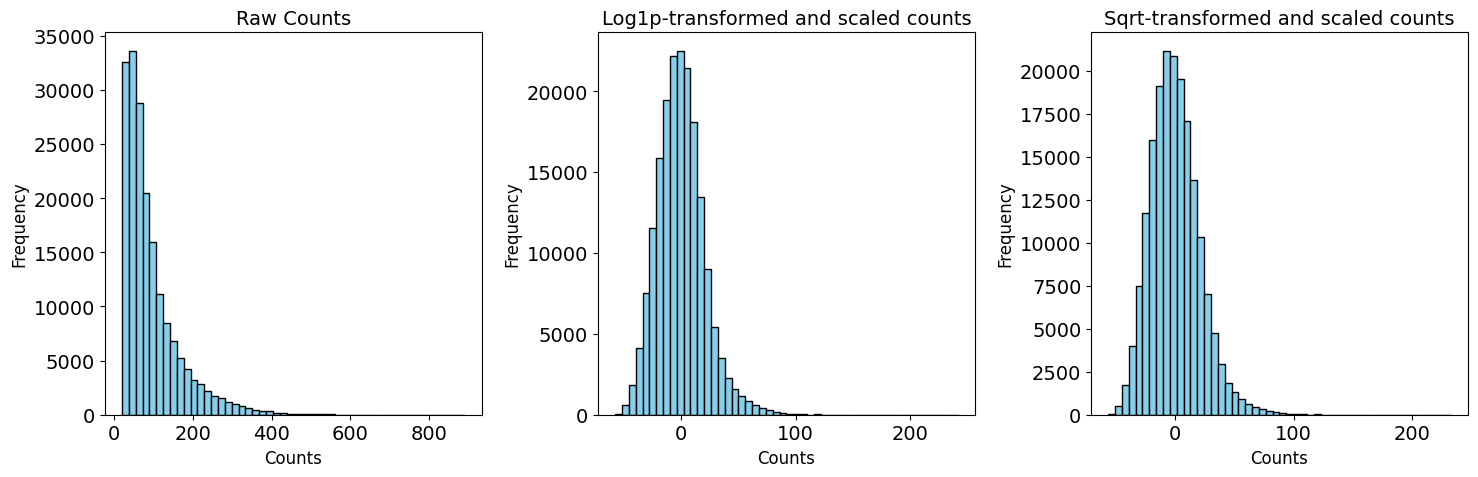

3-main-without scaling


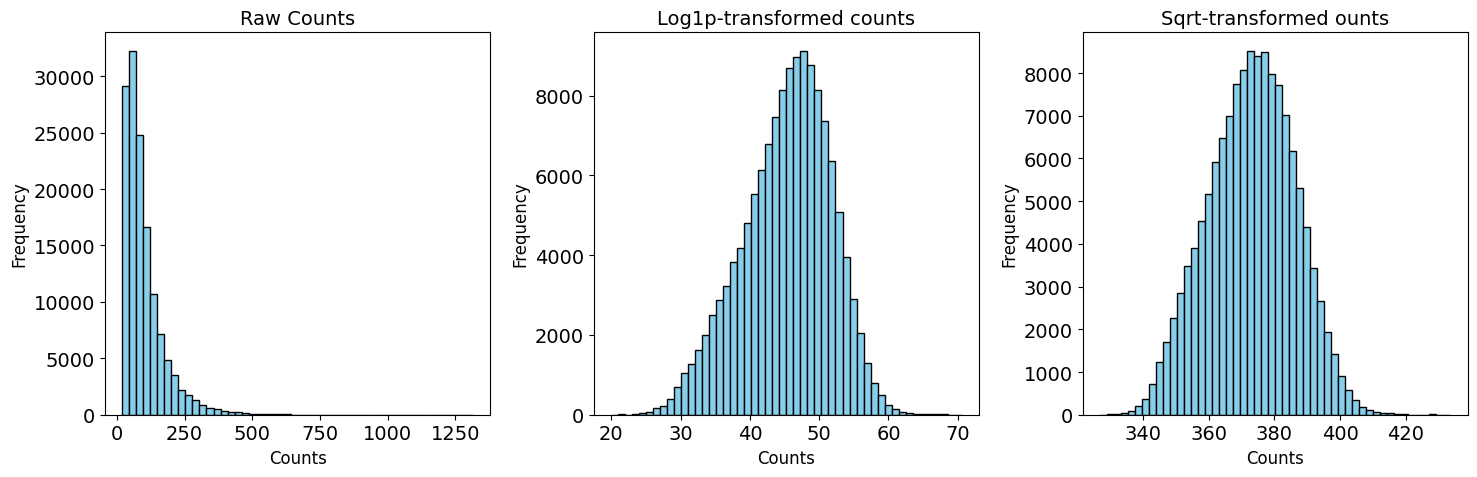

3-main-with scaling


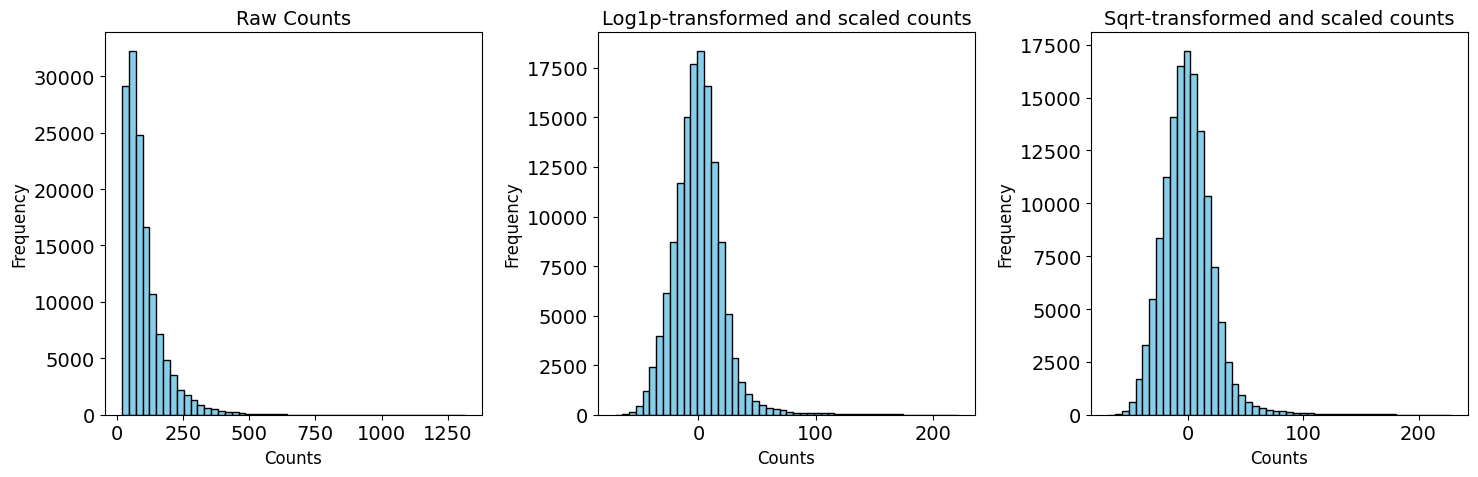

3-proseg-without scaling


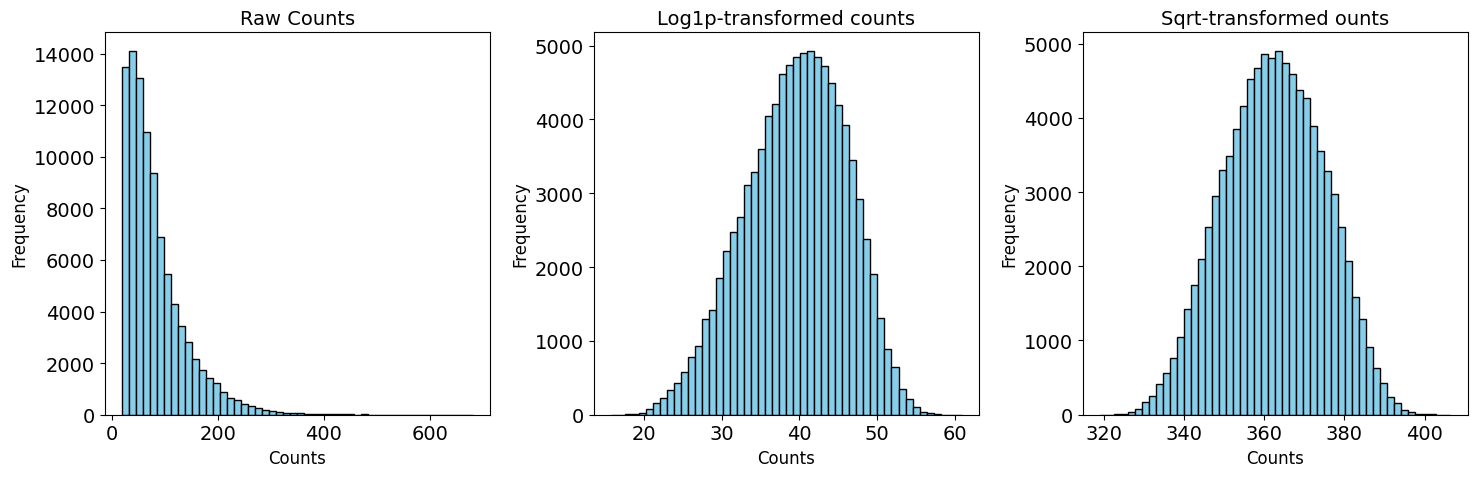

3-proseg-with scaling


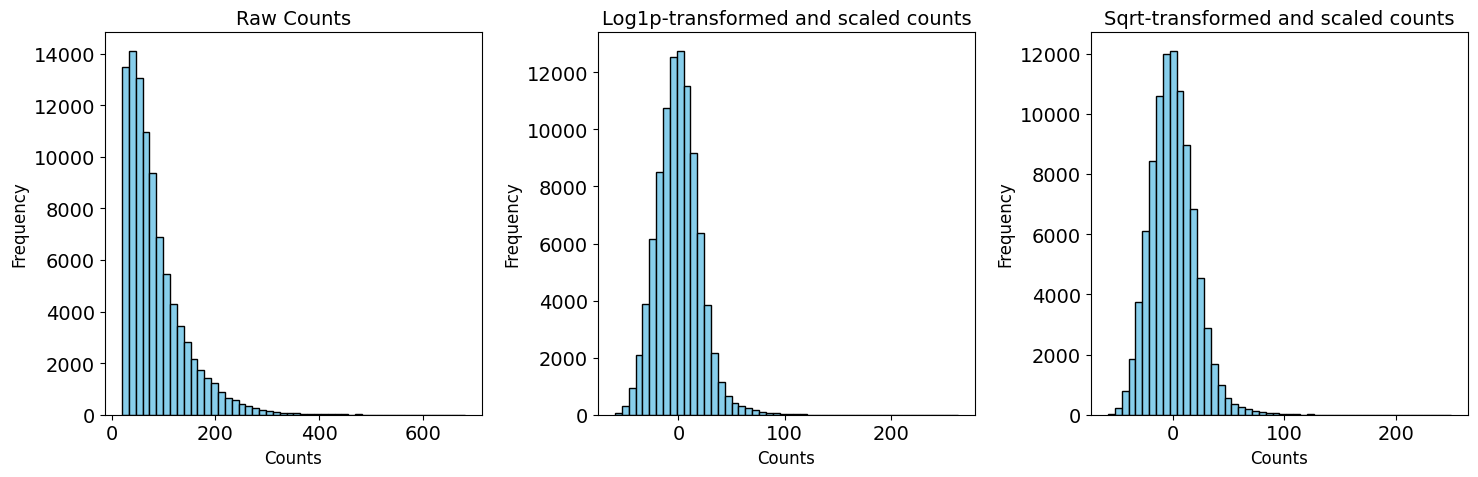

4-main-without scaling


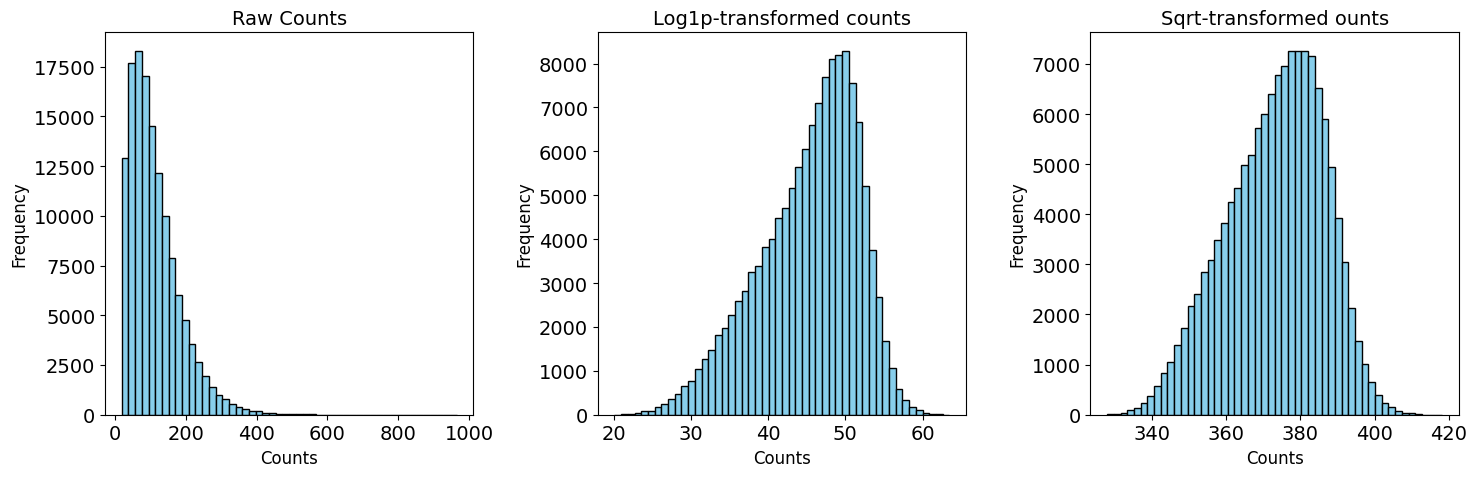

4-main-with scaling


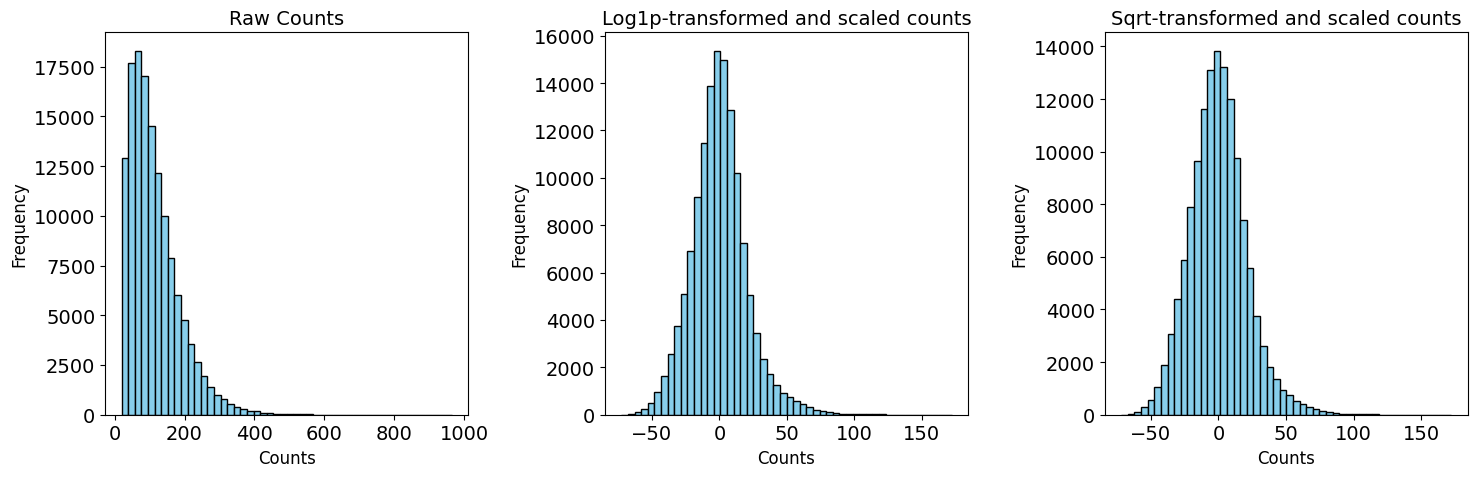

4-proseg-without scaling


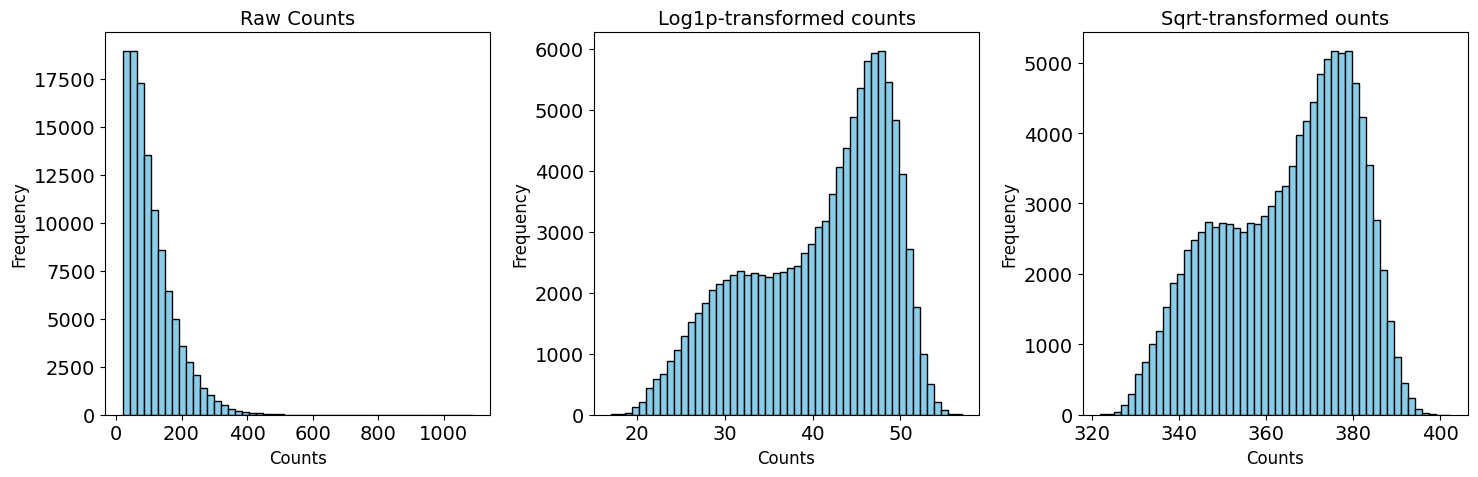

4-proseg-with scaling


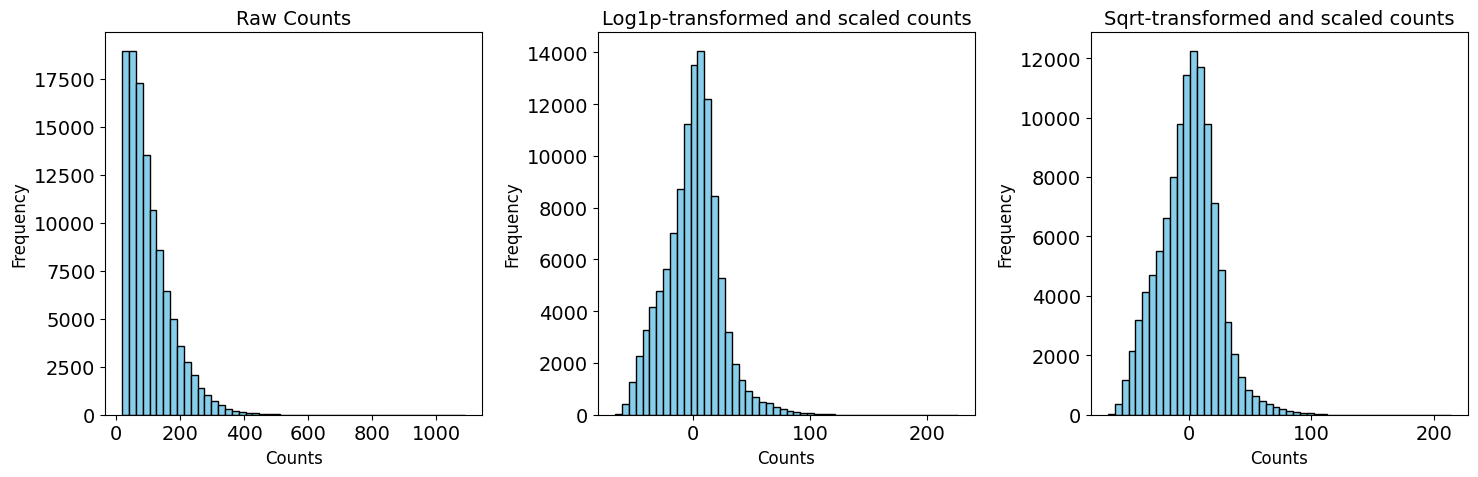

5-main-without scaling


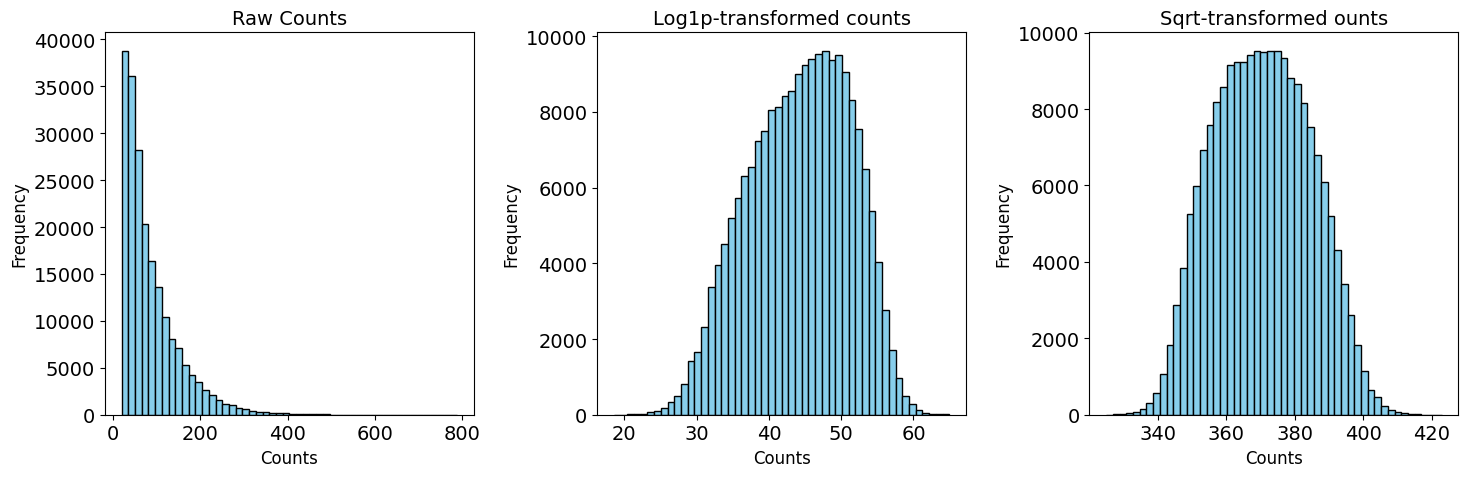

5-main-with scaling


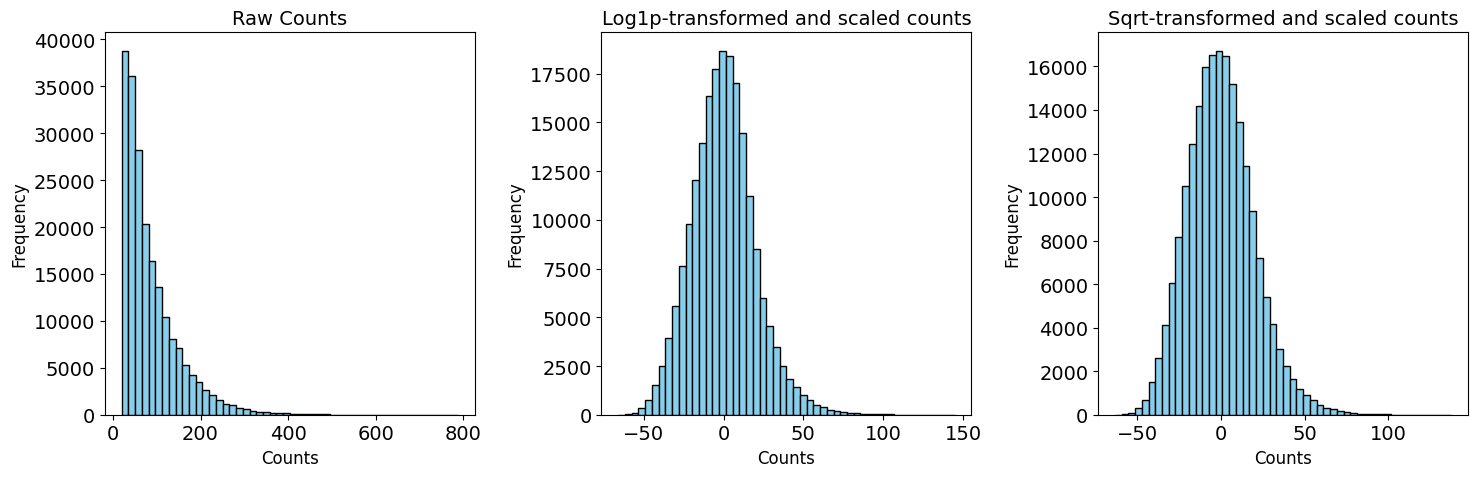

5-proseg-without scaling


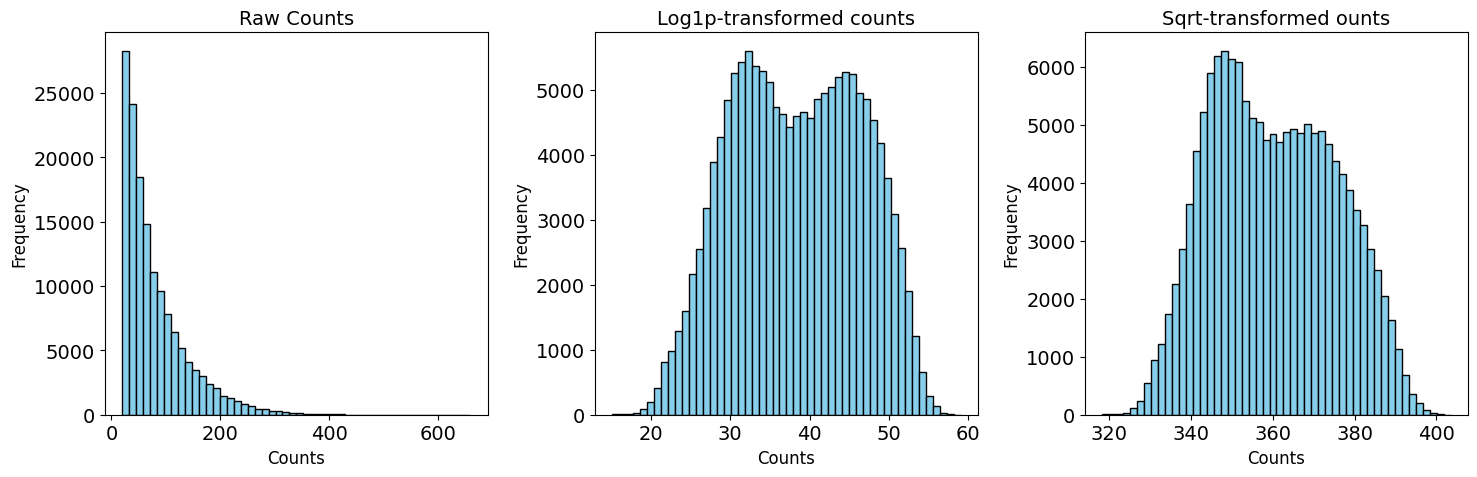

5-proseg-with scaling


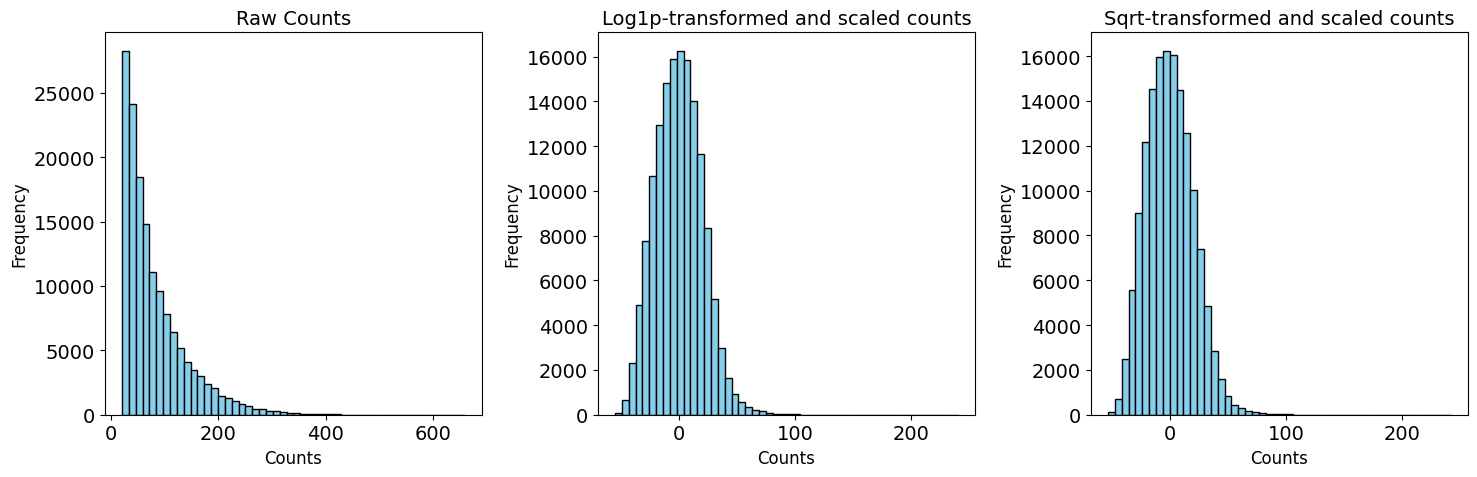

6-main-without scaling


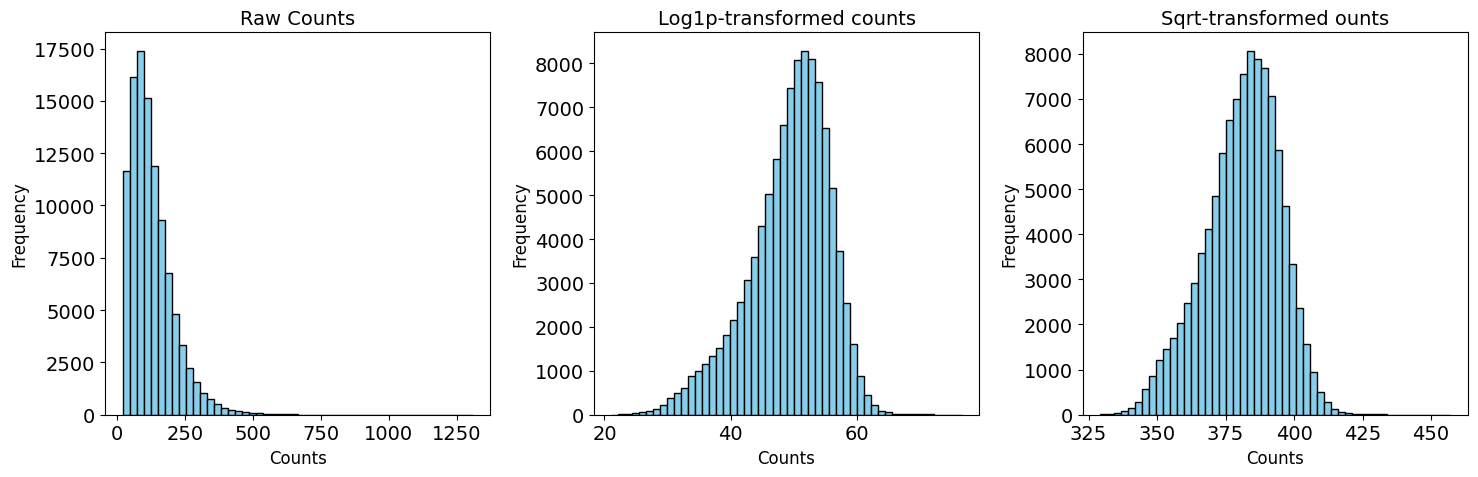

6-main-with scaling


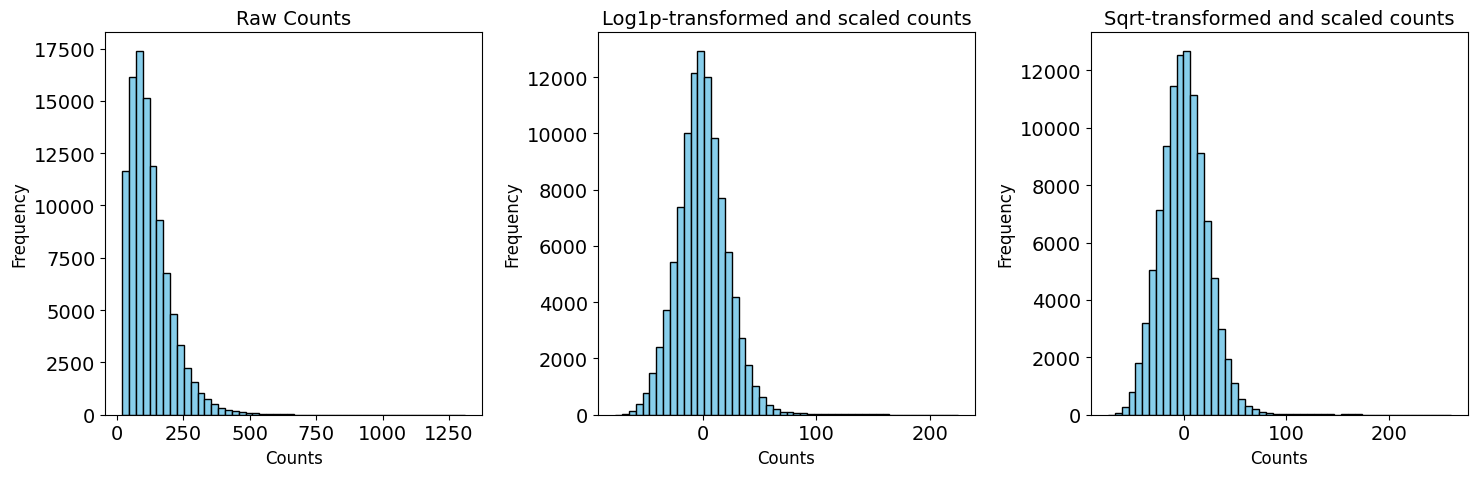

6-proseg-without scaling


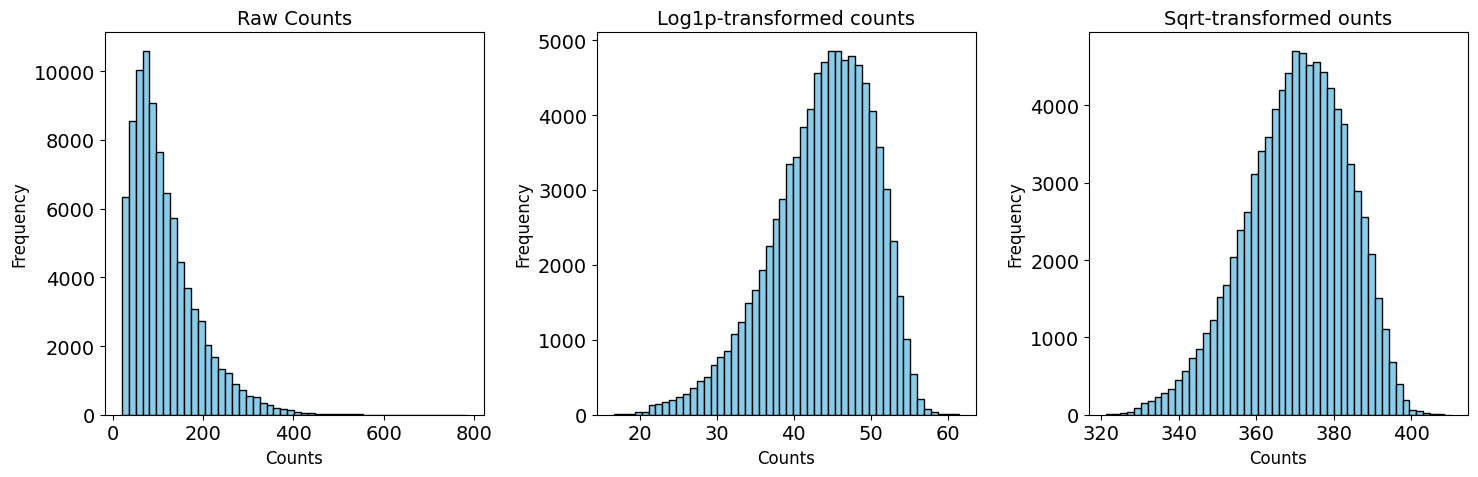

6-proseg-with scaling


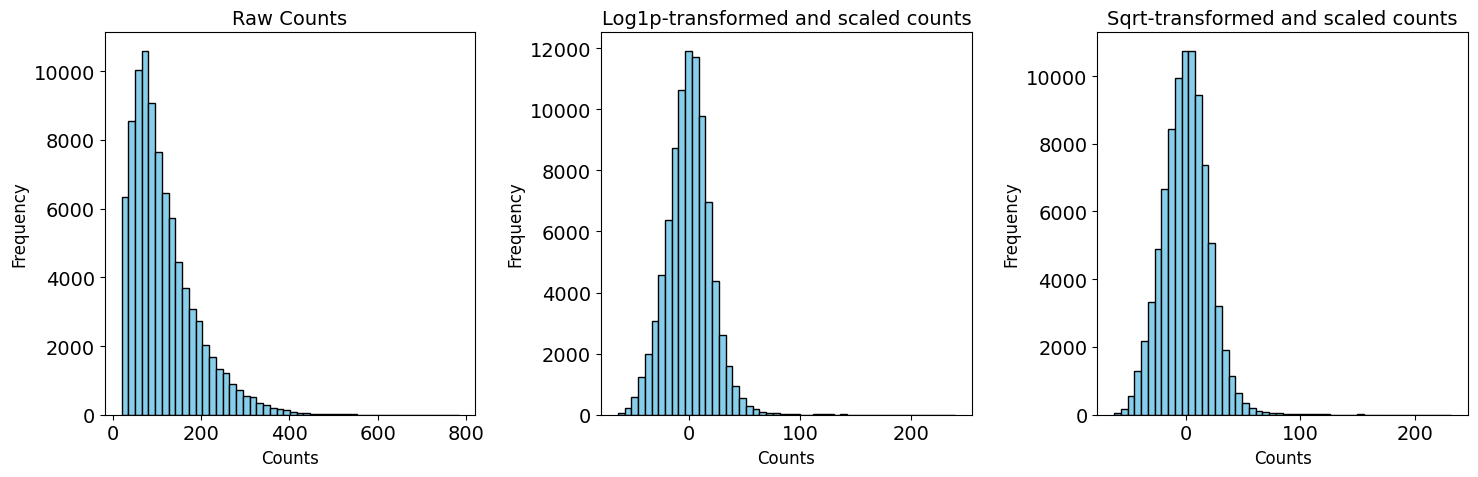

In [42]:
for meta, data in exp.iterdata():
    for k in cell_keys:
        print(f"{meta.name}-{k}-without scaling")
        test_transformations(data=data, cells_layer=k, target_sum=100, scale=False, assert_integer_counts=False)
        print(f"{meta.name}-{k}-with scaling")
        test_transformations(data=data, cells_layer=k, target_sum=100, scale=True, assert_integer_counts=False)

In [43]:
exp

InSituExperiment with 7 samples:
           uid  CITAR  slide_id sample_id  Region  ...           Type     Sample Name Metastasis type              HE           panCK
0     65babf4b  +++--      3621  Region_1       1  ...  primary tumor  Colorectal ...             NaN  ../data/000...  ../data/000...
1     4856f03a  +++--      3621  Region_2       2  ...     metastasis  Lymph node ...     synchronous  ../data/000...  ../data/000...
2     dc3c9ebf  +++--      3621  Region_3       3  ...     metastasis  Lung metast...    asynchronous  ../data/000...  ../data/000...
3     984c3c6b  +++--      3621  Region_4       4  ...     metastasis  Liver metas...     synchronous  ../data/000...  ../data/000...
4     2f211922  +++--      3991  Region_1       1  ...  primary tumor  Colorectal ...             NaN  ../data/000...  ../data/000...
5     369a8637  +++--      3991  Region_2       2  ...     metastasis  Lymph node ...     synchronous  ../data/000...  ../data/000...
6     6bc5f498  +++--      39

In [44]:
from insitupy.preprocessing import normalize_and_transform

In [45]:
normalize_and_transform(
    data=exp,
    cells_layer="main",
    transformation_method='log1p',
    target_sum=100,
    scale=True
)

7it [00:15,  2.24s/it]


In [46]:
normalize_and_transform(
    data=exp,
    cells_layer="proseg",
    transformation_method='log1p',
    target_sum=100,
    scale=True,
    assert_integer_counts=False # proseg counts are not integers
)

7it [00:11,  1.66s/it]


Move scaled data into layers and add the unscaled data into `adata.X`.

In [47]:
for k in cell_keys:
    print(k)
    for _, data in tqdm(exp.iterdata()):
        data.cells[k].matrix.layers[f"scaled_log1p"] = data.cells[k].matrix.X.copy()
        data.cells[k].matrix.X = data.cells[k].matrix.layers["log1p"]

main


7it [00:00,  7.70it/s]


proseg


7it [00:01,  6.79it/s]


# Save data after normalization

In [5]:
pp_path = data_path.parent / "crc_data_pp_rounded"

In [ ]:
exp.saveas(pp_path)

In [7]:
exp = InSituExperiment.read(pp_path)
exp.load_all()

100%|██████████| 7/7 [00:17<00:00,  2.51s/it]


## Export anndatas for cell type annotation

### Check if the obs_names are unique

In [8]:
adata = exp.collect_anndatas(
    cells_layer="proseg",
    obs_keys="all",
    var_keys="all",
    obsm_keys="all",
    layer_keys="counts"
    )

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [26]:
adata

AnnData object with n_obs × n_vars = 1018411 × 280
    obs: 'original_cell_id', 'centroid_x', 'centroid_y', 'centroid_z', 'fov', 'cluster', 'volume', 'scale', 'population', 'n_genes_by_counts', 'total_counts', 'n_counts', 'n_genes', 'uid'
    obsm: 'spatial'
    layers: 'counts'

#### Export anndatas

In [9]:
adata.write(data_path.parent / "adata_export_proseg_rounded.h5ad")